# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
#calling it a second time may prevent some graphics errors
import matplotlib.pyplot as plt

In [2]:
import os
import glob
import git
import sys


In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
# import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [4]:
import umap
from sklearn.preprocessing import StandardScaler
import sklearn.cluster

/blue/npadillacoreano/ryoi360/conda/sleap_1_3_3/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-17 07:39:32.453000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:/opt/slurm/lib64:
2024-07-17 07:39:32.453030: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
import cv2 
import os 

In [6]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [7]:
git_root

'/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/reward_comp_ext'

In [8]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [9]:
import utilities.helper
import sleap.process_pose

In [10]:
from pathlib import Path
import imageio
# import hdbscan

In [11]:
import os 
import cv2  
from PIL import Image  

In [12]:
# sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

# Feature columns

In [13]:
# # based on each subjects individually
# features_columns = ['subject_thorax_velocity', 'agent_thorax_velocity',
#        'subject_thorax_to_agent_thorax', 'subject_nose_to_reward_port',
#        'agent_nose_to_reward_port', 'subject_to_reward_port_angle',
#        'agent_to_reward_port_angle']

In [14]:
frame_difference = 1

In [15]:
smoothing_window = 5

In [16]:
features_columns = ['frame_index',
                    ## Distance metrics
                    'subject_thorax_to_agent_thorax',
                    'nose_to_reward_port_sum',
                    'nose_to_reward_port_diff',
                    ## Velocity and speed metrics
                    'thorax_velocity_sum', 
                    'thorax_velocity_diff',
                    ## Orientation and angle
                    'to_reward_port_angle_sum',
                    'to_reward_port_angle_diff', 
                    # Individual features
                    'subject_nose_to_reward_port',
                    'subject_thorax_velocity',
                    'subject_to_reward_port_angle',
                    'agent_nose_to_reward_port',
                    'agent_thorax_velocity',
                    'agent_to_reward_port_angle',
                    ]

In [17]:
features_columns = ['frame_index',
                    ## Distance metrics
                    'subject_thorax_to_agent_thorax',
                    'nose_to_reward_port_sum',
                    'nose_to_reward_port_diff',
                    'nose_to_tail_sum',
                    'nose_to_tail_diff',
                    ## Velocity and speed metrics
                    'thorax_velocity_sum', 
                    'thorax_velocity_diff',
                    ## Orientation and angle
                    'to_reward_port_angle_sum',
                    'to_reward_port_angle_diff', 
                    # Individual features
                    'subject_nose_to_reward_port',
                    'subject_thorax_velocity',
                    'subject_to_reward_port_angle',
                    'agent_nose_to_reward_port',
                    'agent_thorax_velocity',
                    'agent_to_reward_port_angle',
                    ]

In [18]:
# important_features_columns = ['subject_nose_to_reward_port', 'agent_nose_to_reward_port']
# important_features_columns = ["nose_to_reward_port_sum", "nose_to_reward_port_diff", "subject_thorax_to_agent_thorax"]
important_features_columns =[
## Distance metrics
                    'subject_thorax_to_agent_thorax',
                    'nose_to_reward_port_sum',
                    'nose_to_reward_port_diff',
                    ## Velocity and speed metrics
                    'thorax_velocity_sum', 
                    'thorax_velocity_diff',
                    ## Orientation and angle
                    'to_reward_port_angle_sum',
                    'to_reward_port_angle_diff',]

scaler = 2

# Functions

In [19]:
from scipy.interpolate import interp1d


def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [20]:
def interpolate_nans_in_1d_arr(arr):
    """
    """
    copy_arr = arr.copy()
    nans, x= nan_helper(copy_arr)
    copy_arr[nans] = np.interp(x(nans), x(~nans), copy_arr[~nans])
    return copy_arr

In [21]:
def bools_to_int(row):
    # Convert boolean to integer, then to string, and join to form a binary number string
    binary_string = ''.join(row.astype(int).astype(str))
    # Convert binary string to a decimal integer
    return int(binary_string, 2)

In [22]:
def calculate_angles_from_arrays(A, B, C, D):
    """
    Calculate the angles between vectors AB and CD for arrays of 2D points.

    Parameters:
    - A, B, C, D: Each is a 2D numpy array where each row represents a point in 2D space.
                  A and B represent points defining the first vector, AB, and C and D represent points defining the second vector, CD.

    Returns:
    - A numpy array of angles in degrees between the vectors AB and CD for each set of points.
    """
    # Ensure input arrays are numpy arrays
    A, B, C, D = map(np.array, [A, B, C, D])

    # Calculate vectors AB and CD
    AB = B - A
    CD = D - C

    # Calculate dot products and magnitudes for each pair of vectors
    dot_products = np.einsum('ij,ij->i', AB, CD)
    norms_AB = np.linalg.norm(AB, axis=1)
    norms_CD = np.linalg.norm(CD, axis=1)

    # Calculate cosine of the angle using the dot product and magnitudes
    cos_angles = dot_products / (norms_AB * norms_CD)
    
    # Clip values to prevent domain errors due to numerical issues
    cos_angles = np.clip(cos_angles, -1.0, 1.0)

    # Calculate angles in radians and then convert to degrees
    angles_radians = np.arccos(cos_angles)
    angles_degrees = np.degrees(angles_radians)

    return angles_degrees


In [23]:
def extract_frames(video_path, frame_numbers, output_folder, max_width=640):
    """
    Extracts frames from a video at specific frame numbers and saves them as images.

    Parameters:
        video_path (str): Path to the video file.
        frame_numbers (list): List of frame numbers to extract.
        output_folder (str): Directory to save the frames.
        max_width (int): Maximum width of the frames. Height is adjusted proportionally.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    frame_paths = []
    frame_numbers = [int(num) for num in frame_numbers]
    frame_ids = set(frame_numbers)
    current_frame = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if current_frame in frame_ids:
            # Resize frame if necessary
            height, width = frame.shape[:2]
            if width > max_width:
                scaling_factor = max_width / float(width)
                new_dimensions = (max_width, int(height * scaling_factor))
                frame = cv2.resize(frame, new_dimensions, interpolation=cv2.INTER_AREA)
            
            frame_path = os.path.join(output_folder, "frame_{:05d}.png".format(current_frame))
            cv2.imwrite(frame_path, frame)
            frame_paths.append(frame_path)
            # print(f"Extracted frame {current_frame}")
        
        current_frame += 1
    
    cap.release()
    return frame_paths

In [24]:
def make_video(frame_paths, output_folder, video_name="output.avi", fps=15):
    """
    Creates a video from a list of image frames.

    Parameters:
        frame_paths (list): List of paths to the frame images.
        output_folder (str): Directory to save the video.
        video_name (str): Filename for the video.
        fps (int): Frames per second for the video.
    """
    if not frame_paths:
        print("No frames to make a video.")
        return

    frame = cv2.imread(frame_paths[0])
    height, width, layers = frame.shape

    video_path = os.path.join(output_folder, video_name)
    video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

    for frame_path in frame_paths:
        video.write(cv2.imread(frame_path))

    video.release()
    print(f"Video saved to {video_path}")

In [25]:
def extract_frames_and_make_video(video_path, frame_numbers, output_folder, video_name="output.gif", fps=25, max_width=640):
    """
    Extracts frames from a video at specific frame numbers, resizes them, and creates a GIF from those frames.

    Parameters:
        video_path (str): Path to the video file.
        frame_numbers (list): List of frame numbers to extract.
        output_folder (str): Directory to save the frames and GIF.
        gif_name (str): Filename for the GIF.
        fps (int): Frames per second for the GIF.
        max_width (int): Maximum width of the frames in the GIF. Height is adjusted proportionally.
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Prepare to extract frames
    frames = []
    frame_ids = set(frame_numbers)  # Convert list to set for faster lookup
    current_frame = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if current_frame in frame_ids:
            # Resize frame to reduce GIF size
            height, width = frame.shape[:2]
            scaling_factor = max_width / float(width)
            if width > max_width:  # Only resize if the image is wider than the max width
                new_dim = (max_width, int(height * scaling_factor))
                frame = cv2.resize(frame, new_dim, interpolation=cv2.INTER_AREA)
            
            frame_path = os.path.join(output_folder, f"frame_{current_frame}.png")
            cv2.imwrite(frame_path, frame)
            frames.append(frame_path)
            print(f"Extracted frame {current_frame}")
        
        current_frame += 1
    
    # Close video file
    cap.release()

    frame = cv2.imread(frames[0]) 
  
    # setting the frame width, height width 
    # the width, height of first image 
    height, width, layers = frame.shape   
  
    video = cv2.VideoWriter(os.path.join(output_folder, video_name), 0, fps, (width, height))  
  
    # Appending the images to the video one by one 
    for image in frames:  
        video.write(cv2.imread(image))  
      
    # Deallocating memories taken for window creation 
    cv2.destroyAllWindows()  
    video.release()  # releasing the video generated 
  

In [26]:
def extract_frames_and_make_gif(video_path, frame_numbers, output_folder, gif_name="output.gif", fps=25, max_width=640):
    """
    Extracts frames from a video at specific frame numbers, resizes them, and creates a GIF from those frames.

    Parameters:
        video_path (str): Path to the video file.
        frame_numbers (list): List of frame numbers to extract.
        output_folder (str): Directory to save the frames and GIF.
        gif_name (str): Filename for the GIF.
        fps (int): Frames per second for the GIF.
        max_width (int): Maximum width of the frames in the GIF. Height is adjusted proportionally.
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Prepare to extract frames
    frames = []
    frame_ids = set(frame_numbers)  # Convert list to set for faster lookup
    current_frame = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if current_frame in frame_ids:
            # Resize frame to reduce GIF size
            height, width = frame.shape[:2]
            scaling_factor = max_width / float(width)
            if width > max_width:  # Only resize if the image is wider than the max width
                new_dim = (max_width, int(height * scaling_factor))
                frame = cv2.resize(frame, new_dim, interpolation=cv2.INTER_AREA)
            
            frame_path = os.path.join(output_folder, f"frame_{current_frame}.png")
            cv2.imwrite(frame_path, frame)
            frames.append(frame_path)
            print(f"Extracted frame {current_frame}")
        
        current_frame += 1
    
    # Close video file
    cap.release()

    # Create GIF
    if frames:
        with imageio.get_writer(os.path.join(output_folder, gif_name), mode='I', fps=fps) as writer:
            for filename in frames:
                image = imageio.imread(filename)
                writer.append_data(image)
        print(f"GIF created at {os.path.join(output_folder, gif_name)}")
    else:
        print("No frames extracted, GIF not created.")

In [27]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

In [28]:
def calculate_speed_from_distances(distances_array, window_size=25, polynomial_order=3):
    """
    Compute the speed of an object moving along a path defined by distances covered over time. 
    The speed is calculated by smoothing the distances using the Savitzky-Golay filter to find 
    the rate of change of distance with respect to time (derivative), which represents the speed.

    Parameters:
    ----------
    distances_array : numpy.ndarray
        An array containing distances covered over consecutive frames or time intervals. 
        Each value should represent the distance moved from the previous frame or time interval.
        
    window_size : int, optional
        The length of the filter window, i.e., the number of coefficients. `window_size` must be a positive odd number.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial used to fit the samples. `polynomial_order` must be less than `window_size`.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        An array of the smoothed rate of change of distances, representing the speed for each frame or time interval.

    Notes:
    -----
    - The function assumes that the input distances are sequential and represent uniform time intervals.
    - The rate of change (speed) is computed using the first derivative with respect to the distance data.
    """
    # Validate input
    if polynomial_order >= window_size:
        raise ValueError("polynomial_order must be less than window_size")
    
    # Calculate the rate of change of the distance to get speed, using Savitzky-Golay filter
    speed = savgol_filter(distances_array, window_size, polynomial_order, deriv=1)

    return speed

In [29]:
# def calculate_speed_from_distances(distances, dt):
#     """
#     Calculate the speed from a numpy array of distances measured at regular time intervals.

#     Parameters:
#         distances (np.array): 1D Numpy array where each element represents a distance measured at a specific time.
#         dt (float): Time interval between consecutive distance measurements.

#     Returns:
#         np.array: Array of speeds calculated as the change in distance divided by the time interval.
#     """
#     # Calculate the change in distance
#     delta_distances = np.diff(distances, n=dt)

#     # Calculate speeds as change in distance divided by change in time
#     speeds = delta_distances / dt

#     # Pad the speed array at the beginning with zero to maintain the same length
#     speeds = np.concatenate([np.array([speeds[0]]), speeds])

#     return speeds

In [30]:
def rolling_average(arr, window_size):
    """
    Computes the rolling average using a specified window size.
    
    Parameters:
        arr (numpy.array): The input array to compute the rolling average for.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.array: The rolling average of the input array.
    """
    if window_size < 1:
       raise ValueError("Window size must be at least 1.")
    
    # Create a uniform window of given window size
    window = np.ones(window_size) / window_size

    # Use numpy's convolve function to compute the rolling average
    return np.convolve(arr, window, mode='valid')



In [31]:
def chunked_average(arr, chunk_size):
    """
    Computes the average for non-overlapping chunks of the input array.
    
    Parameters:
        arr (numpy.array): The input array.
        chunk_size (int): The size of each chunk.

    Returns:
        numpy.array: The averages of the non-overlapping chunks.
    """

    # Number of chunks
    num_chunks = len(arr) // chunk_size
    
    # Reshape the array into a 2D array of shape (num_chunks, chunk_size)
    reshaped_arr = arr[:num_chunks * chunk_size].reshape(num_chunks, chunk_size)
    
    # Compute the mean along the second axis (i.e., for each chunk)
    return reshaped_arr.mean(axis=1)

In [32]:
def sliding_window_average(arr, window_size, step=1):
    """
    Apply a sliding window to a 1D numpy array, returning the average of windows of a specified size.

    :param arr: Input 1D numpy array.
    :param window_size: Size of the window.
    :param step: The step size or number of elements to slide the window by. Default is 1.
    :return: A 1D numpy array where each element is the average of a window from the input.
    """
    # Number of windows
    num_windows = ((arr.size - window_size) // step) + 1
    
    # Output array for averages
    averages = np.zeros(num_windows)
    
    for i in range(num_windows):
        # Calculate the start and end index for the window
        start = i * step
        end = start + window_size
        # Calculate the average of the window
        averages[i] = np.mean(arr[start:end])

    return averages

In [33]:
def calculate_all_window_indices(original_index, window_size, step, array_length):
    """
    Calculate all the start and stop indices for sliding windows based on an original start index.

    :param original_index: The original index from which the first window should start.
    :param window_size: The size of each sliding window.
    :param step: The step size or number of elements to slide the window by.
    :param array_length: The total number of elements in the array.
    :return: A list of tuples, each containing the start and stop indices for a sliding window.
    """

    # Initialize the list to hold the start and stop indices for all windows
    windows = []

    # Initialize the current start index with the original index
    current_start_index = original_index

    # Loop through the array until the end is reached
    while current_start_index + window_size <= original_index + array_length:
        # Calculate the stop index based on the window size
        stop_index = current_start_index + window_size

        # Add the start and stop indices to the list
        windows.append((current_start_index, stop_index))

        # Update the current start index by adding the step size
        current_start_index += step

    return windows

In [34]:
def calculate_angle(ax, ay, bx, by, cx, cy):
    """
    Calculate the smallest angle between the vectors BA and BC with all points given in Cartesian coordinates.

    Parameters:
        ax, ay (float): Coordinates of point A.
        bx, by (float): Coordinates of point B, the vertex of the angle.
        cx, cy (float): Coordinates of point C.

    Returns:
        float: The smallest angle between vectors BA and BC, in radians, within the range [0, pi].
    """
    # Calculate the angles of vectors BA and BC relative to the positive x-axis
    ang_ba = np.arctan2(ay - by, ax - bx)
    ang_bc = np.arctan2(cy - by, cx - bx)

    # Compute the difference of angles
    ang = ang_bc - ang_ba

    # Normalize the angle to the range [0, 2*pi)
    ang = (ang + 2 * np.pi) % (2 * np.pi)

    # Ensure the angle is within [0, pi]
    if ang > np.pi:
        ang = 2 * np.pi - ang

    return ang

# Example usage:
ax, ay = 0, 1  # Coordinates for point A
bx, by = 0, 0  # Coordinates for point B (origin)
cx, cy = -0.5, 0.5  # Coordinates for point C

angle = calculate_angle(ax, ay, bx, by, cx, cy)
print("Angle in radians:", angle)
print("Angle in degrees:", np.degrees(angle))

Angle in radians: 0.7853981633974483
Angle in degrees: 45.0


In [35]:
def calculate_time_series_angles(A, B, C):
    """
    Calculate the smallest angle between vectors BA and BC for arrays of 2D points over time.

    Parameters:
        A, B, C (np.array): Each is a 2D numpy array of shape (T, 2) where T is the number of time steps.
                            Each array holds the x and y coordinates of points A, B, and C over time.

    Returns:
        np.array: Array of smallest angles between vectors BA and BC, in radians, within the range [0, pi].
    """
    # Extract x and y coordinates
    ax, ay = A[:, 0], A[:, 1]
    bx, by = B[:, 0], B[:, 1]
    cx, cy = C[:, 0], C[:, 1]
    
    # Calculate the angles of vectors BA and BC relative to the positive x-axis
    ang_ba = np.arctan2(ay - by, ax - bx)
    ang_bc = np.arctan2(cy - by, cx - bx)
    
    # Compute the difference of angles
    ang = ang_bc - ang_ba
    
    # Normalize the angle to the range [0, 2*pi)
    ang = (ang + 2 * np.pi) % (2 * np.pi)
    
    # Ensure the angle is within [0, pi]
    ang[ang > np.pi] = 2 * np.pi - ang[ang > np.pi]
    
    return ang

In [36]:
# Concatenating and stacking arrays from all columns
def concat_arrays(row):
    return np.hstack(row)



In [37]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## Inputs & Data

Explanation of each input and where it comes from.

In [38]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1

# LFP_SPECTRAL_DF = pd.read_pickle("./proc/rce_pilot_2_03_spectral_bands.pkl")
# LFP_SPECTRAL_DF["video_name"] = LFP_SPECTRAL_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync"))

# SLEAP_DIR = os.path.join(git_root, "proc/sleap") 
# SLEAP_DIR = "/scratch/back_up/reward_competition_extention/final_proc/id_corrected"
SLEAP_DIR = "./data"

OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
WINDOW_SIZE = 25
DISTANCE_THRESHOLD = 2

In [39]:
all_start_stop_files = ["./data/rce_pilot_2_per_subject_start_stop_video_frame.xlsx",
"./data/rce_pilot_3_long_comp_per_subject_start_stop_video_frame.xlsx",
"./data/rce_pilot_3_alone_comp_per_subject_start_stop_video_frame.xlsx",
"./data/rce_pilot_3_omission_per_subject_start_stop_video_frame.xlsx"]

In [40]:
all_trials_files = ["./data/rce_pilot_3_omission_per_video_trial_labels.xlsx",
"./data/rce_pilot_3_long_comp_per_video_trial_labels.xlsx",
"./data/rce_pilot_3_alone_comp_per_video_trial_labels.xlsx",
"./data/rce_pilot_2_per_video_trial_labels.xlsx"]

In [41]:
# all_start_stop_files = ["./data/rce_pilot_3_long_comp_per_subject_start_stop_video_frame.xlsx"]

In [42]:
# all_trials_files = ["./data/rce_pilot_3_long_comp_per_video_trial_labels.xlsx"]

In [43]:
list_of_start_stop_df = []

for file_path in all_start_stop_files:
    current_df = pd.read_excel(file_path)
    list_of_start_stop_df.append(current_df)

START_STOP_FRAME_DF = pd.concat(list_of_start_stop_df)


In [44]:
START_STOP_FRAME_DF

,file_path,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,notes
0,20221214_125409_om_and_comp_6_1_and_6_3.1.1_su...,1,25000,6.3,6.1_6.3,1,NaN
1,20221214_125409_om_and_comp_6_1_and_6_3.1.2_su...,27500,73600,6.1_6.3,6.1_6.3,1,NaN
2,20221215_145401_comp_amd_om_6_1_and_6_3.1.1_su...,51500,76454,6.3,6.1_6.3,1,NaN
3,20221215_145401_comp_amd_om_6_1_and_6_3.1.2_su...,1,48500,6.1_6.3,6.1_6.3,1,NaN
4,20230612_112630_standard_comp_to_training_D1_s...,32700,68257,1.2,1.1_1.2,1,NaN
...,...,...,...,...,...,...,...
4,20240317_105929_comp_om_subj_5-3_and_5-4.1.fix...,1,31000,5.3_5.4,5.3_5.4,1,NaN
5,20240318_115841_comp_om_subj_5-2_and_5-3.1.fix...,1,31000,5.2_5.3,5.2_5.3,1,NaN
6,20240319_111204_comp_om_subj_5-2_and_5-4.1.fix...,1,31000,5.2_5.4,5.2_5.4,1,NaN
7,20240325_125522_comp_om_subj_3-1_and_3-4.1.fix...,1,30500,3.1_3.4,3.1_3.4,1,NaN


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [45]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_3"

In [46]:
FULL_LFP_TRACES_PKL = "{}_04_spectral_and_sleap.pkl".format(OUTPUT_PREFIX)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

# Getting the videos where the subject is in the recording

### Looking at when each subject was in each video

In [47]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset=["file_path"])

- Getting the name of the SLEAP and video files where each subject was in

In [48]:
START_STOP_FRAME_DF["sleap_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: os.path.basename(x))
START_STOP_FRAME_DF["video_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: ".".join(os.path.basename(x).split(".")[:2]))
START_STOP_FRAME_DF["start_frame"] = START_STOP_FRAME_DF["start_frame"].astype(int)
START_STOP_FRAME_DF["stop_frame"] = START_STOP_FRAME_DF["stop_frame"].astype(int)

In [49]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(columns=["file_path", "notes"], errors="ignore")

In [50]:
START_STOP_FRAME_DF["video_name"].unique()

array(['20221214_125409_om_and_comp_6_1_and_6_3.1',
       '20221215_145401_comp_amd_om_6_1_and_6_3.1',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.2',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.2',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.2',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.3',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.1',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.2',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.3',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1',
       '

In [51]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name
0,1,25000,6.3,6.1_6.3,1,20221214_125409_om_and_comp_6_1_and_6_3.1.1_su...,20221214_125409_om_and_comp_6_1_and_6_3.1
1,27500,73600,6.1_6.3,6.1_6.3,1,20221214_125409_om_and_comp_6_1_and_6_3.1.2_su...,20221214_125409_om_and_comp_6_1_and_6_3.1
2,51500,76454,6.3,6.1_6.3,1,20221215_145401_comp_amd_om_6_1_and_6_3.1.1_su...,20221215_145401_comp_amd_om_6_1_and_6_3.1
3,1,48500,6.1_6.3,6.1_6.3,1,20221215_145401_comp_amd_om_6_1_and_6_3.1.2_su...,20221215_145401_comp_amd_om_6_1_and_6_3.1
4,32700,68257,1.2,1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...


- Splitting each row into seperate row for each subject in the video

In [52]:
START_STOP_FRAME_DF["tracked_subject"] = START_STOP_FRAME_DF["tracked_subject"].apply(lambda x: str(x).split("_"))
START_STOP_FRAME_DF["current_subject"] = START_STOP_FRAME_DF["tracked_subject"]

In [53]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.explode("current_subject")

In [54]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject
0,1,25000,[6.3],6.1_6.3,1,20221214_125409_om_and_comp_6_1_and_6_3.1.1_su...,20221214_125409_om_and_comp_6_1_and_6_3.1,6.3
1,27500,73600,"[6.1, 6.3]",6.1_6.3,1,20221214_125409_om_and_comp_6_1_and_6_3.1.2_su...,20221214_125409_om_and_comp_6_1_and_6_3.1,6.1
1,27500,73600,"[6.1, 6.3]",6.1_6.3,1,20221214_125409_om_and_comp_6_1_and_6_3.1.2_su...,20221214_125409_om_and_comp_6_1_and_6_3.1,6.3
2,51500,76454,[6.3],6.1_6.3,1,20221215_145401_comp_amd_om_6_1_and_6_3.1.1_su...,20221215_145401_comp_amd_om_6_1_and_6_3.1,6.3
3,1,48500,"[6.1, 6.3]",6.1_6.3,1,20221215_145401_comp_amd_om_6_1_and_6_3.1.2_su...,20221215_145401_comp_amd_om_6_1_and_6_3.1,6.1


In [55]:
START_STOP_FRAME_DF.shape

(125, 8)

# Reading in the h5 files between recordings

In [56]:
SLEAP_DIR

'./data'

In [57]:
START_STOP_FRAME_DF["sleap_name"] = START_STOP_FRAME_DF["video_name"].apply(lambda x: "{}.fixed.2_subj.round_3.id_corrected.h5".format(x))

In [58]:
START_STOP_FRAME_DF["sleap_name"].iloc[0]

'20221214_125409_om_and_comp_6_1_and_6_3.1.fixed.2_subj.round_3.id_corrected.h5'

In [59]:
START_STOP_FRAME_DF["sleap_name"]

0    20221214_125409_om_and_comp_6_1_and_6_3.1.fixe...
1    20221214_125409_om_and_comp_6_1_and_6_3.1.fixe...
1    20221214_125409_om_and_comp_6_1_and_6_3.1.fixe...
2    20221215_145401_comp_amd_om_6_1_and_6_3.1.fixe...
3    20221215_145401_comp_amd_om_6_1_and_6_3.1.fixe...
                           ...                        
6    20240319_111204_comp_om_subj_5-2_and_5-4.1.fix...
7    20240325_125522_comp_om_subj_3-1_and_3-4.1.fix...
7    20240325_125522_comp_om_subj_3-1_and_3-4.1.fix...
8    20240325_150329_comp_om_subj_4-2_and_4-4.1.fix...
8    20240325_150329_comp_om_subj_4-2_and_4-4.1.fix...
Name: sleap_name, Length: 125, dtype: object

In [60]:
START_STOP_FRAME_DF["sleap_glob"] = START_STOP_FRAME_DF["sleap_name"].apply(lambda x: glob.glob(os.path.join(SLEAP_DIR, "**", x)))


In [61]:
for name in START_STOP_FRAME_DF[START_STOP_FRAME_DF["sleap_glob"].apply(lambda x: len(x) == 0)]["sleap_name"]:
    print(name)

20221214_125409_om_and_comp_6_1_and_6_3.1.fixed.2_subj.round_3.id_corrected.h5
20221214_125409_om_and_comp_6_1_and_6_3.1.fixed.2_subj.round_3.id_corrected.h5
20221214_125409_om_and_comp_6_1_and_6_3.1.fixed.2_subj.round_3.id_corrected.h5
20221215_145401_comp_amd_om_6_1_and_6_3.1.fixed.2_subj.round_3.id_corrected.h5
20221215_145401_comp_amd_om_6_1_and_6_3.1.fixed.2_subj.round_3.id_corrected.h5
20221215_145401_comp_amd_om_6_1_and_6_3.1.fixed.2_subj.round_3.id_corrected.h5
20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.2.fixed.2_subj.round_3.id_corrected.h5
20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.2.fixed.2_subj.round_3.id_corrected.h5
20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.2.fixed.2_subj.round_3.id_corrected.h5
20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.3.fixed.2_subj.round_3.id_corrected.h5
20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.2.fixed.2_subj.round_3.id_corrected.h5
20230617_115521_stand

# TODO FIX SLEAP GLOB

In [62]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF['sleap_glob'].apply(lambda x: len(x) >= 1)]
START_STOP_FRAME_DF = START_STOP_FRAME_DF.reset_index(drop=True)




In [63]:
START_STOP_FRAME_DF["sleap_path"] = START_STOP_FRAME_DF["sleap_glob"].apply(lambda x: x[0])

In [64]:
START_STOP_FRAME_DF["sleap_path"]

0     ./data/20230612_112630_standard_comp_to_traini...
1     ./data/20230612_112630_standard_comp_to_traini...
2     ./data/20230612_112630_standard_comp_to_traini...
3     ./data/20230613_105657_standard_comp_to_traini...
4     ./data/20230613_105657_standard_comp_to_traini...
                            ...                        
62    ./data/20240319_111204_comp_om_subj_5-2_and_5-...
63    ./data/20240325_125522_comp_om_subj_3-1_and_3-...
64    ./data/20240325_125522_comp_om_subj_3-1_and_3-...
65    ./data/20240325_150329_comp_om_subj_4-2_and_4-...
66    ./data/20240325_150329_comp_om_subj_4-2_and_4-...
Name: sleap_path, Length: 67, dtype: object

In [65]:
START_STOP_FRAME_DF["all_sleap_data"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: sleap.process_pose.extract_sleap_data(x))


In [66]:
START_STOP_FRAME_DF["body_parts"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [67]:
START_STOP_FRAME_DF["body_parts"].iloc[0]

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

In [68]:
START_STOP_FRAME_DF["locations"] = START_STOP_FRAME_DF["all_sleap_data"].apply(lambda x: x["locations"])

In [69]:
START_STOP_FRAME_DF["track_names"] = START_STOP_FRAME_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [70]:
START_STOP_FRAME_DF["locations"].iloc[0].shape

(68258, 6, 2, 2)

In [71]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,all_sleap_data,body_parts,locations,track_names
0,32700,68257,[1.2],1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,{'locations': [[[[243.57579041 335.84069824] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[243.57579041 335.84069824], [396.37969971 ...","[1.1, 1.2]"
1,1,32300,"[1.1, 1.2]",1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,{'locations': [[[[243.57579041 335.84069824] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[243.57579041 335.84069824], [396.37969971 ...","[1.1, 1.2]"
2,1,32300,"[1.1, 1.2]",1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,{'locations': [[[[243.57579041 335.84069824] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[243.57579041 335.84069824], [396.37969971 ...","[1.1, 1.2]"
3,33400,68332,[1.1],1.1_1.4,1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,{'locations': [[[[339.77365112 362.56900024] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[339.77365112 362.56900024], [400.29354858 ...","[1.1, 1.4]"
4,1,33000,"[1.1, 1.4]",1.1_1.4,1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,{'locations': [[[[339.77365112 362.56900024] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[339.77365112 362.56900024], [400.29354858 ...","[1.1, 1.4]"


In [72]:
# Getting the indexes of each subject from the track list
START_STOP_FRAME_DF["subject_to_index"] = START_STOP_FRAME_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["tracked_subject"] if k in x["track_names"]}, axis=1)

In [73]:
START_STOP_FRAME_DF["subject_to_index"].head()

0              {'1.2': 1}
1    {'1.1': 0, '1.2': 1}
2    {'1.1': 0, '1.2': 1}
3              {'1.1': 0}
4    {'1.1': 0, '1.4': 1}
Name: subject_to_index, dtype: object

In [74]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [75]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [76]:
START_STOP_FRAME_DF["subject_to_tracks"].head()

0    {'1.2': [[[335.84069824 128.25213623], [300.47...
1    {'1.1': [[[243.57579041 396.37969971], [247.22...
2    {'1.1': [[[243.57579041 396.37969971], [247.22...
3    {'1.1': [[[339.77365112 400.29354858], [316.26...
4    {'1.1': [[[339.77365112 400.29354858], [316.26...
Name: subject_to_tracks, dtype: object

In [77]:
START_STOP_FRAME_DF["subject_to_tracks"].apply(lambda x: x.keys()).head()

0         (1.2)
1    (1.1, 1.2)
2    (1.1, 1.2)
3         (1.1)
4    (1.1, 1.4)
Name: subject_to_tracks, dtype: object

In [78]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,all_sleap_data,body_parts,locations,track_names,subject_to_index,subject_to_tracks
0,32700,68257,[1.2],1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,{'locations': [[[[243.57579041 335.84069824] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[243.57579041 335.84069824], [396.37969971 ...","[1.1, 1.2]",{'1.2': 1},"{'1.2': [[[335.84069824 128.25213623], [300.47..."
1,1,32300,"[1.1, 1.2]",1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,{'locations': [[[[243.57579041 335.84069824] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[243.57579041 335.84069824], [396.37969971 ...","[1.1, 1.2]","{'1.1': 0, '1.2': 1}","{'1.1': [[[243.57579041 396.37969971], [247.22..."
2,1,32300,"[1.1, 1.2]",1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,{'locations': [[[[243.57579041 335.84069824] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[243.57579041 335.84069824], [396.37969971 ...","[1.1, 1.2]","{'1.1': 0, '1.2': 1}","{'1.1': [[[243.57579041 396.37969971], [247.22..."
3,33400,68332,[1.1],1.1_1.4,1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,{'locations': [[[[339.77365112 362.56900024] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[339.77365112 362.56900024], [400.29354858 ...","[1.1, 1.4]",{'1.1': 0},"{'1.1': [[[339.77365112 400.29354858], [316.26..."
4,1,33000,"[1.1, 1.4]",1.1_1.4,1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,{'locations': [[[[339.77365112 362.56900024] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[339.77365112 362.56900024], [400.29354858 ...","[1.1, 1.4]","{'1.1': 0, '1.4': 1}","{'1.1': [[[339.77365112 400.29354858], [316.26..."


## Getting the coordinates of the corners

In [79]:
START_STOP_FRAME_DF["sleap_path"].iloc[0]

'./data/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.fixed.2_subj.round_3.id_corrected.h5'

In [80]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
START_STOP_FRAME_DF["corner_path"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: x.replace("id_corrected.h5", "corner.h5").replace(".fixed", "").replace(".round_1", "").replace(".round_3", "").replace(".1_subj", "").replace(".2_subj", ""))


In [81]:
for path in START_STOP_FRAME_DF["corner_path"]:
    print(path)

./data/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.corner.h5
./data/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.corner.h5
./data/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.corner.h5
./data/20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4/20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1.corner.h5
./data/20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4/20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1.corner.h5
./data/20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4/20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1.corner.h5
./data/20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2/20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1.corner.h5

In [82]:
START_STOP_FRAME_DF["corner_path"].iloc[0]

'./data/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.corner.h5'

In [83]:
# Getting the indexes of each corner location
START_STOP_FRAME_DF["corner_parts"] = START_STOP_FRAME_DF["corner_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [84]:
START_STOP_FRAME_DF["corner_parts"]

0     [box_top_left, box_top_right, reward_port, box...
1     [box_top_left, box_top_right, reward_port, box...
2     [box_top_left, box_top_right, reward_port, box...
3     [box_bottom_left, box_top_right, reward_port, ...
4     [box_bottom_left, box_top_right, reward_port, ...
                            ...                        
62    [box_top_right, box_bottom_right, box_top_left...
63    [box_top_right, box_bottom_right, box_top_left...
64    [box_top_right, box_bottom_right, box_top_left...
65    [box_top_right, box_bottom_right, box_top_left...
66    [box_top_right, box_bottom_right, box_top_left...
Name: corner_parts, Length: 67, dtype: object

In [85]:
# TODO: Remove this once corner files are fixed
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF["corner_parts"].apply(lambda x: "reward_port" in x)]

In [86]:
# Getting the coordinates of all the corners
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF["corner_path"].apply(lambda x: sleap.process_pose.get_sleap_tracks_from_h5(x))

In [87]:
# Parsing out each corner and creating a dictionary of name to coordinates
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [88]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_left': [[[nan], [nan]], [[nan], [nan...
1     {'box_top_left': [[[nan], [nan]], [[nan], [nan...
2     {'box_top_left': [[[nan], [nan]], [[nan], [nan...
3     {'box_bottom_left': [[[219.49634883], [382.936...
4     {'box_bottom_left': [[[219.49634883], [382.936...
                            ...                        
62    {'box_top_right': [[[808.88741044], [174.19419...
63    {'box_top_right': [[[794.94313168], [142.80035...
64    {'box_top_right': [[[794.94313168], [142.80035...
65    {'box_top_right': [[[800.17214397], [149.29454...
66    {'box_top_right': [[[800.17214397], [149.29454...
Name: corner_to_coordinate, Length: 67, dtype: object

In [89]:
# Filtering out all the Nans because there's only one labeled frame
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF.apply(lambda x: {k: v[~np.isnan(v)][:2] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [90]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_left': [215.09666220678088, 113.9234...
1     {'box_top_left': [215.09666220678088, 113.9234...
2     {'box_top_left': [215.09666220678088, 113.9234...
3     {'box_bottom_left': [219.49634882813532, 382.9...
4     {'box_bottom_left': [219.49634882813532, 382.9...
                            ...                        
62    {'box_top_right': [808.8874104404782, 174.1941...
63    {'box_top_right': [794.9431316763704, 142.8003...
64    {'box_top_right': [794.9431316763704, 142.8003...
65    {'box_top_right': [800.1721439749609, 149.2945...
66    {'box_top_right': [800.1721439749609, 149.2945...
Name: corner_to_coordinate, Length: 67, dtype: object

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [91]:
# Using the x-coordinates for the width
START_STOP_FRAME_DF["bottom_width"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
START_STOP_FRAME_DF["top_width"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [92]:
# Using the y-coordinates for the height
START_STOP_FRAME_DF["right_height"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
START_STOP_FRAME_DF["left_height"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [93]:
# averaging the width and height by adding both sides and then getting the mean
START_STOP_FRAME_DF["average_height"] = START_STOP_FRAME_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
START_STOP_FRAME_DF["average_width"] = START_STOP_FRAME_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [94]:
START_STOP_FRAME_DF["width_ratio"] = MED_PC_WIDTH / START_STOP_FRAME_DF["average_width"]
START_STOP_FRAME_DF["height_ratio"] = MED_PC_HEIGHT / START_STOP_FRAME_DF["average_height"]

In [95]:
START_STOP_FRAME_DF["height_ratio"]

0     0.089984
1     0.089984
2     0.089984
3     0.091180
4     0.091180
        ...   
62    0.060675
63    0.060079
64    0.060079
65    0.061077
66    0.061077
Name: height_ratio, Length: 67, dtype: float64

## Converting Pixels to cm

In [96]:
START_STOP_FRAME_DF["in_video_subjects"] = START_STOP_FRAME_DF["in_video_subjects"].apply(lambda x: x.split("_"))

In [97]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k: v for k, v in x["subject_to_tracks"].items() if k in x["in_video_subjects"]}, axis=1)

- Converting the X-dimension

In [98]:
START_STOP_FRAME_DF["subject_to_tracks"].head()

0    {'1.2': [[[335.84069824 128.25213623], [300.47...
1    {'1.1': [[[243.57579041 396.37969971], [247.22...
2    {'1.1': [[[243.57579041 396.37969971], [247.22...
3    {'1.1': [[[339.77365112 400.29354858], [316.26...
4    {'1.1': [[[339.77365112 400.29354858], [316.26...
Name: subject_to_tracks, dtype: object

In [99]:
START_STOP_FRAME_DF["rescaled_locations"] = START_STOP_FRAME_DF.apply(lambda x: {key: sleap.process_pose.fill_missing(sleap.process_pose.rescale_dimension_in_array(value, dimension=0, ratio=x["width_ratio"])) for key, value in x["subject_to_tracks"].items()}, axis=1)

- Converting the Y-dimension

In [100]:
START_STOP_FRAME_DF["rescaled_locations"] = START_STOP_FRAME_DF.apply(lambda x: {key: sleap.process_pose.rescale_dimension_in_array(value, dimension=1, ratio=x["height_ratio"]) for key, value in x["rescaled_locations"].items()}, axis=1)

In [101]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_left': [215.09666220678088, 113.9234...
1     {'box_top_left': [215.09666220678088, 113.9234...
2     {'box_top_left': [215.09666220678088, 113.9234...
3     {'box_bottom_left': [219.49634882813532, 382.9...
4     {'box_bottom_left': [219.49634882813532, 382.9...
                            ...                        
62    {'box_top_right': [808.8874104404782, 174.1941...
63    {'box_top_right': [794.9431316763704, 142.8003...
64    {'box_top_right': [794.9431316763704, 142.8003...
65    {'box_top_right': [800.1721439749609, 149.2945...
66    {'box_top_right': [800.1721439749609, 149.2945...
Name: corner_to_coordinate, Length: 67, dtype: object

In [102]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,corner_to_coordinate,bottom_width,top_width,right_height,left_height,average_height,average_width,width_ratio,height_ratio,rescaled_locations
0,32700,68257,[1.2],"[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,"{'box_top_left': [215.09666220678088, 113.9234...",209.287764,210.248994,267.077370,266.353718,266.715544,209.768379,0.140631,0.089984,"{'1.2': [[[47.22971434 11.54057699], [42.25662..."
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,"{'box_top_left': [215.09666220678088, 113.9234...",209.287764,210.248994,267.077370,266.353718,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[34.25438031 35.66763544], [34.76795..."
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,"{'box_top_left': [215.09666220678088, 113.9234...",209.287764,210.248994,267.077370,266.353718,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[34.25438031 35.66763544], [34.76795..."
3,33400,68332,[1.1],"[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,...,"{'box_bottom_left': [219.49634882813532, 382.9...",213.213618,211.523940,263.471488,262.958532,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[47.19772262 36.49884996], [43.93209..."
4,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,...,"{'box_bottom_left': [219.49634882813532, 382.9...",213.213618,211.523940,263.471488,262.958532,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[47.19772262 36.49884996], [43.93209..."


In [103]:
# Normalize dictionary column
normalized = pd.json_normalize(START_STOP_FRAME_DF["corner_to_coordinate"])

In [104]:
normalized.head()

,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,"[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
1,"[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
2,"[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
3,"[211.8445364825192, 119.97841708068698]","[423.3684762341395, 112.2997417613741]","[326.19769332642636, 399.0248601049142]","[219.49634882813532, 382.9369493804368]","[432.7099664053751, 375.77122988087467]"
4,"[211.8445364825192, 119.97841708068698]","[423.3684762341395, 112.2997417613741]","[326.19769332642636, 399.0248601049142]","[219.49634882813532, 382.9369493804368]","[432.7099664053751, 375.77122988087467]"


In [105]:


# Drop the original column and concat the normalized DataFrame
START_STOP_FRAME_DF = pd.concat([START_STOP_FRAME_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [106]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,32700,68257,[1.2],"[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,266.715544,209.768379,0.140631,0.089984,"{'1.2': [[[47.22971434 11.54057699], [42.25662...","[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[34.25438031 35.66763544], [34.76795...","[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[34.25438031 35.66763544], [34.76795...","[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
3,33400,68332,[1.1],"[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,...,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[47.19772262 36.49884996], [43.93209...","[211.8445364825192, 119.97841708068698]","[423.3684762341395, 112.2997417613741]","[326.19769332642636, 399.0248601049142]","[219.49634882813532, 382.9369493804368]","[432.7099664053751, 375.77122988087467]"
4,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,...,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[47.19772262 36.49884996], [43.93209...","[211.8445364825192, 119.97841708068698]","[423.3684762341395, 112.2997417613741]","[326.19769332642636, 399.0248601049142]","[219.49634882813532, 382.9369493804368]","[432.7099664053751, 375.77122988087467]"


In [107]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset=["reward_port"])

- Converting the corner coordinates into cms

In [108]:
for corner in START_STOP_FRAME_DF["corner_parts"].iloc[0]:
    START_STOP_FRAME_DF[corner] = START_STOP_FRAME_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

## Looking over the tracks

In [109]:
FILE_INDEX = 0

In [110]:
START_STOP_FRAME_DF["sleap_path"].iloc[FILE_INDEX]

'./data/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.fixed.2_subj.round_3.id_corrected.h5'

In [111]:
START_STOP_FRAME_DF["rescaled_locations"].head()

0    {'1.2': [[[47.22971434 11.54057699], [42.25662...
1    {'1.1': [[[34.25438031 35.66763544], [34.76795...
2    {'1.1': [[[34.25438031 35.66763544], [34.76795...
3    {'1.1': [[[47.19772262 36.49884996], [43.93209...
4    {'1.1': [[[47.19772262 36.49884996], [43.93209...
Name: rescaled_locations, dtype: object

In [112]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'sleap_glob', 'sleap_path', 'all_sleap_data', 'body_parts', 'locations',
       'track_names', 'subject_to_index', 'subject_to_tracks', 'corner_path',
       'corner_parts', 'bottom_width', 'top_width', 'right_height',
       'left_height', 'average_height', 'average_width', 'width_ratio',
       'height_ratio', 'rescaled_locations', 'box_top_left', 'box_top_right',
       'reward_port', 'box_bottom_left', 'box_bottom_right'],
      dtype='object')

In [113]:
with h5py.File(START_STOP_FRAME_DF["sleap_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    current_subject = START_STOP_FRAME_DF["current_subject"].iloc[FILE_INDEX]
    locations = START_STOP_FRAME_DF["rescaled_locations"].iloc[FILE_INDEX][current_subject]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(68258, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [114]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

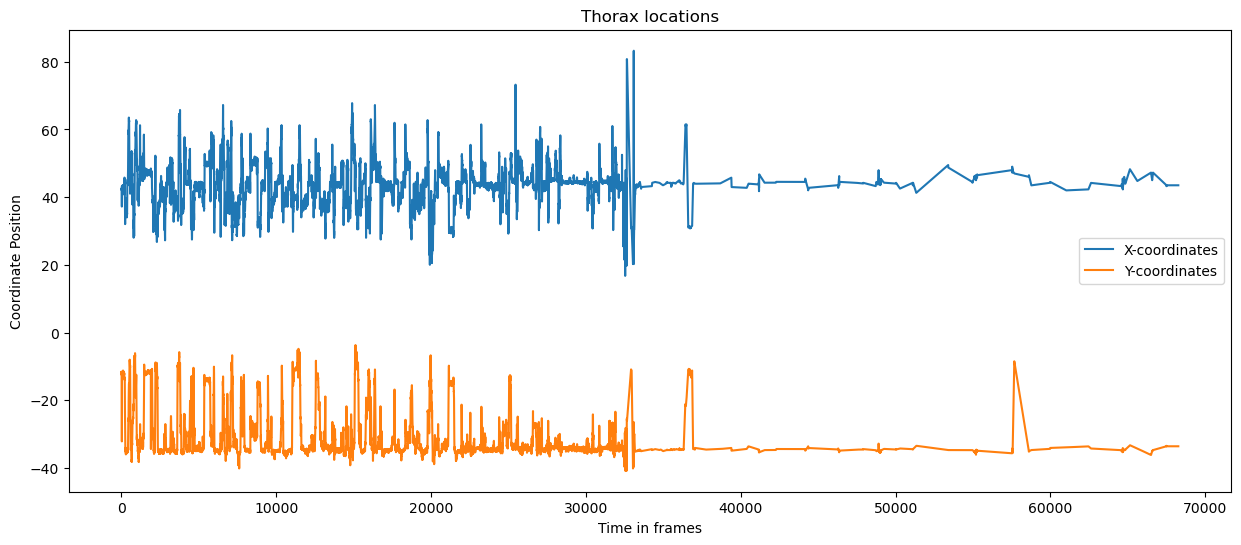

In [115]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

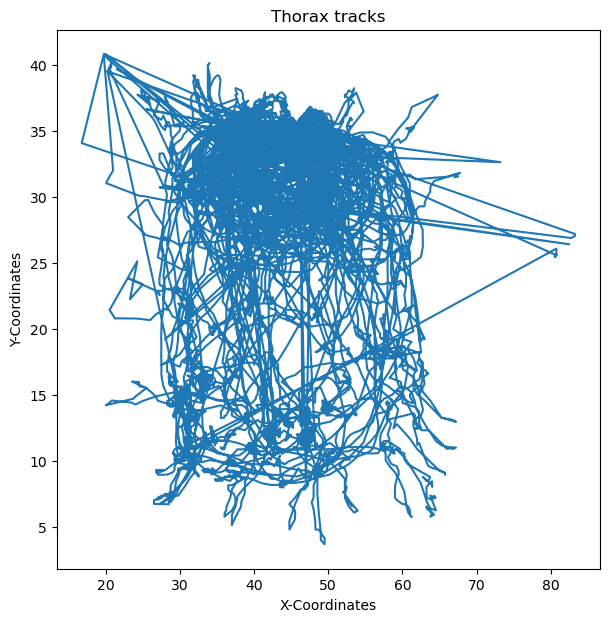

In [116]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


## Creating an individual column for each pose tracking

In [117]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset=["current_subject"])

In [118]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,32700,68257,[1.2],"[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,266.715544,209.768379,0.140631,0.089984,"{'1.2': [[[47.22971434 11.54057699], [42.25662...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]"
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[34.25438031 35.66763544], [34.76795...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]"
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[34.25438031 35.66763544], [34.76795...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]"
3,33400,68332,[1.1],"[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,...,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[47.19772262 36.49884996], [43.93209...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]"
4,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,...,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[47.19772262 36.49884996], [43.93209...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]"


In [119]:
START_STOP_FRAME_DF["tracked_subject"]

0          [1.2]
1     [1.1, 1.2]
2     [1.1, 1.2]
3          [1.1]
4     [1.1, 1.4]
         ...    
62    [5.2, 5.4]
63    [3.1, 3.4]
64    [3.1, 3.4]
65    [4.2, 4.4]
66    [4.2, 4.4]
Name: tracked_subject, Length: 67, dtype: object

In [120]:
START_STOP_FRAME_DF["agent"] = START_STOP_FRAME_DF.apply(lambda x: list((set(x["tracked_subject"]) - set([x["current_subject"]]))), axis=1)

In [121]:
START_STOP_FRAME_DF[START_STOP_FRAME_DF["agent"].apply(lambda x: len(x) != 1)]

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right,agent
0,32700,68257,[1.2],"[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,209.768379,0.140631,0.089984,"{'1.2': [[[47.22971434 11.54057699], [42.25662...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",[]
3,33400,68332,[1.1],"[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,...,212.368779,0.138909,0.091180,"{'1.1': [[[47.19772262 36.49884996], [43.93209...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",[]
6,32800,44205,[1.1],"[1.1, 1.2]",1,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,1.1,[./data/20230614_114041_standard_comp_to_train...,./data/20230614_114041_standard_comp_to_traini...,...,212.714155,0.138684,0.091993,"{'1.1': [[[52.51888343 36.28326548], [52.00764...","[29.10707058981441, 11.364487226798616]","[58.883863567261514, 10.806271116252097]","[45.44232917370965, 36.91440422283628]","[30.339373669373565, 35.17083382117832]","[59.562580691926456, 34.99992452187238]",[]
9,32100,67369,[1.4],"[1.2, 1.4]",1,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,1.4,[./data/20230616_111904_standard_comp_to_train...,./data/20230616_111904_standard_comp_to_traini...,...,210.226016,0.140325,0.090895,"{'1.4': [[[57.35729372 25.35640086], [54.88894...","[29.86625143627433, 11.124724603015066]","[59.38334890344171, 10.604275828952773]","[45.69464614292888, 36.59658123160905]","[30.926534526401632, 34.86353305048207]","[60.40943705923425, 34.86546738148577]",[]
12,32792,68494,[1.4],"[1.1, 1.4]",1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,[./data/20230618_100636_standard_comp_to_omiss...,./data/20230618_100636_standard_comp_to_omissi...,...,214.308233,0.137652,0.092440,"{'1.4': [[[29.38287222 31.23016828], [33.75629...","[28.94954695212123, 11.559275766924861]","[58.25716394690266, 11.0851249161892]","[44.59493426883317, 37.290222508536225]","[29.794023445649177, 35.275466614423074]","[59.48640645086775, 35.36893406869099]",[]
15,32860,68287,[1.2],"[1.1, 1.2]",1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,1.2,[./data/20230620_114347_standard_comp_to_omiss...,./data/20230620_114347_standard_comp_to_omissi...,...,214.647754,0.137434,0.090034,"{'1.2': [[[43.00100041 33.44266356], [41.30614...","[28.726306016601946, 10.842459364362139]","[58.282641339237685, 10.501152914297204]","[44.54098011165848, 36.54165425213083]","[30.091010784999508, 34.98257973535351]","[59.534675462363765, 34.36103254330584]",[]
18,35000,69766,[1.4],"[1.2, 1.4]",1,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,1.4,[./data/20230621_111240_standard_comp_to_omiss...,./data/20230621_111240_standard_comp_to_omissi...,...,212.292023,0.138960,0.091223,"{'1.4': [[[51.66789997 35.99393557], [49.14967...","[29.368871804533384, 11.233148401733333]","[58.98052434827515, 10.969818829118575]","[45.157453324589945, 36.79799744676499]","[30.292670448640752, 35.366774292703255]","[59.6810179048989

In [122]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF["tracked_subject"].apply(lambda x: len(x) == 2)]

In [123]:
START_STOP_FRAME_DF["agent"] = START_STOP_FRAME_DF["agent"].apply(lambda x: x[0] if len(x) == 1 else None)

In [124]:
START_STOP_FRAME_DF["agent"]

1     1.2
2     1.1
4     1.4
5     1.1
7     1.2
8     1.1
10    1.4
11    1.2
13    1.4
14    1.1
16    1.2
17    1.1
19    1.4
20    1.2
21    3.3
22    3.1
23    4.3
24    4.2
25    3.4
26    3.3
27    4.4
28    4.3
29    3.4
30    3.1
31    4.4
32    4.2
33    5.4
34    5.3
35    5.3
36    5.2
37    4.3
38    4.2
39    3.4
40    3.3
41    4.4
42    4.3
43    5.3
44    5.2
45    3.4
46    3.1
47    4.4
48    4.2
49    4.3
50    4.2
51    3.3
52    3.1
53    4.4
54    4.3
55    3.4
56    3.3
57    5.4
58    5.3
59    5.3
60    5.2
61    5.4
62    5.2
63    3.4
64    3.1
65    4.4
66    4.2
Name: agent, dtype: object

In [125]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right,agent
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,209.768379,0.140631,0.089984,"{'1.1': [[[34.25438031 35.66763544], [34.76795...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.2
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[./data/20230612_112630_standard_comp_to_train...,./data/20230612_112630_standard_comp_to_traini...,...,209.768379,0.140631,0.089984,"{'1.1': [[[34.25438031 35.66763544], [34.76795...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.1
4,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,...,212.368779,0.138909,0.091180,"{'1.1': [[[47.19772262 36.49884996], [43.93209...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.4
5,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.4,[./data/20230613_105657_standard_comp_to_train...,./data/20230613_105657_standard_comp_to_traini...,...,212.368779,0.138909,0.091180,"{'1.1': [[[47.19772262 36.49884996], [43.93209...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.1
7,1,32200,"[1.1, 1.2]","[1.1, 1.2]",1,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,1.1,[./data/20230614_114041_standard_comp_to_train...,./data/20230614_114041_standard_comp_to_traini...,...,212.714155,0.138684,0.091993,"{'1.1': [[[52.51888343 36.28326548], [52.00764...","[29.10707058981441, 11.364487226798616]","[58.883863567261514, 10.806271116252097]","[45.44232917370965, 36.91440422283628]","[30.339373669373565, 35.17083382117832]","[59.562580691926456, 34.99992452187238]",1.2


In [126]:
START_STOP_FRAME_DF["subject_locations"] = START_STOP_FRAME_DF.apply(lambda x: x["rescaled_locations"][x["current_subject"]] , axis=1)

In [127]:
START_STOP_FRAME_DF["agent_locations"] = START_STOP_FRAME_DF.apply(lambda x: x["rescaled_locations"].get(x["agent"], np.nan) if x["agent"] else np.nan, axis=1)

## Getting all the timestamps

In [128]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'sleap_glob', 'sleap_path', 'all_sleap_data', 'body_parts', 'locations',
       'track_names', 'subject_to_index', 'subject_to_tracks', 'corner_path',
       'corner_parts', 'bottom_width', 'top_width', 'right_height',
       'left_height', 'average_height', 'average_width', 'width_ratio',
       'height_ratio', 'rescaled_locations', 'box_top_left', 'box_top_right',
       'reward_port', 'box_bottom_left', 'box_bottom_right', 'agent',
       'subject_locations', 'agent_locations'],
      dtype='object')

In [129]:
START_STOP_FRAME_DF["frame_index"] = START_STOP_FRAME_DF["subject_locations"].apply(lambda x: np.arange(0, x.shape[0]) + 1)

## Removing unnecessary columns

In [130]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(["sleap_glob", "subject_to_index", "subject_to_tracks", "corner_parts", "corner_to_coordinate", "bottom_width", "top_width", "right_height", "left_height", "average_height", "average_width", "width_ratio", "height_ratio", 'locations', 'track_names', 'sleap_path', 'corner_path', 'all_sleap_data', 'rescaled_locations'], errors="ignore", axis=1)

In [131]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'body_parts', 'box_top_left', 'box_top_right', 'reward_port',
       'box_bottom_left', 'box_bottom_right', 'agent', 'subject_locations',
       'agent_locations', 'frame_index'],
      dtype='object')

In [132]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,body_parts,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right,agent,subject_locations,agent_locations,frame_index
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.2,"[[[34.25438031064355, 35.667635444835575], [34...","[[[47.229714341638875, 11.540576985831455], [4...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.1,"[[[47.229714341638875, 11.540576985831455], [4...","[[[34.25438031064355, 35.667635444835575], [34...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.4,"[[[47.197722618012605, 36.49884996438671], [43...","[[[50.364208780909664, 10.861847428311039], [5...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
5,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.1,"[[[50.364208780909664, 10.861847428311039], [5...","[[[47.197722618012605, 36.49884996438671], [43...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
7,1,32200,"[1.1, 1.2]","[1.1, 1.2]",1,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.10707058981441, 11.364487226798616]","[58.883863567261514, 10.806271116252097]","[45.44232917370965, 36.91440422283628]","[30.339373669373565, 35.17083382117832]","[59.562580691926456, 34.99992452187238]",1.2,"[[[52.518883426095876, 36.28326548413289], [52...","[[[44.894543657007155, 33.83744818008539], [44...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


# Calculate relavant features

## Features to calculate

1. velocity of the mice
2. distance between thoraxes
3. distances to port of mice
4. angles of orientation of mice to port




Original features to calculate
1. distance between thoraxes
2. velocity of mouse 1 + velocity of mouse 2
3. | velocity of mouse 1 - velocity of mouse 2 |
4. sum of angles of orientation of mice to port
5. | difference of angles of orientation of mice to port |
6. sum of distances to port of mice
7. | differences of distances to port of mice |

In [133]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'body_parts', 'box_top_left', 'box_top_right', 'reward_port',
       'box_bottom_left', 'box_bottom_right', 'agent', 'subject_locations',
       'agent_locations', 'frame_index'],
      dtype='object')

# Getting relavent body parts

In [134]:
START_STOP_FRAME_DF["body_parts"].apply(lambda x: x.index("thorax"))

1     4
2     4
4     4
5     4
7     4
8     4
10    4
11    4
13    4
14    4
16    4
17    4
19    4
20    4
21    4
22    4
23    4
24    4
25    4
26    4
27    4
28    4
29    4
30    4
31    4
32    4
33    4
34    4
35    4
36    4
37    4
38    4
39    4
40    4
41    4
42    4
43    4
44    4
45    4
46    4
47    4
48    4
49    4
50    4
51    4
52    4
53    4
54    4
55    4
56    4
57    4
58    4
59    4
60    4
61    4
62    4
63    4
64    4
65    4
66    4
Name: body_parts, dtype: int64

In [135]:
START_STOP_FRAME_DF["subject_thorax"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_locations"][:,x["body_parts"].index("thorax"),:], axis=1)
START_STOP_FRAME_DF["subject_nose"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_locations"][:,x["body_parts"].index("nose"),:], axis=1)
START_STOP_FRAME_DF["subject_tail_base"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_locations"][:,x["body_parts"].index("tail_base"),:], axis=1)


In [136]:
START_STOP_FRAME_DF["agent_thorax"] = START_STOP_FRAME_DF.apply(lambda x: x["agent_locations"][:,x["body_parts"].index("thorax"),:], axis=1)
START_STOP_FRAME_DF["agent_nose"] = START_STOP_FRAME_DF.apply(lambda x: x["agent_locations"][:,x["body_parts"].index("nose"),:], axis=1)
START_STOP_FRAME_DF["agent_tail_base"] = START_STOP_FRAME_DF.apply(lambda x: x["agent_locations"][:,x["body_parts"].index("tail_base"),:], axis=1)


In [137]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,body_parts,box_top_left,...,agent,subject_locations,agent_locations,frame_index,subject_thorax,subject_nose,subject_tail_base,agent_thorax,agent_nose,agent_tail_base
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]",...,1.2,"[[[34.25438031064355, 35.667635444835575], [34...","[[[47.229714341638875, 11.540576985831455], [4...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[39.52385035395619, 34.4047879939674], [39.75...","[[32.24815257269072, 34.21344397609933], [32.2...","[[43.24533105018797, 34.074110688844804], [43....","[[45.00564713899357, 9.423307742464585], [45.0...","[[45.26381166791732, 14.406486324022024], [45....","[[49.00673383082635, 9.416220799854717], [48.7..."
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]",...,1.1,"[[[47.229714341638875, 11.540576985831455], [4...","[[[34.25438031064355, 35.667635444835575], [34...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[45.00564713899357, 9.423307742464585], [45.0...","[[45.26381166791732, 14.406486324022024], [45....","[[49.00673383082635, 9.416220799854717], [48.7...","[[39.52385035395619, 34.4047879939674], [39.75...","[[32.24815257269072, 34.21344397609933], [32.2...","[[43.24533105018797, 34.074110688844804], [43...."
4,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.42717788149638, 10.939657307701639]",...,1.4,"[[[47.197722618012605, 36.49884996438671], [43...","[[[50.364208780909664, 10.861847428311039], [5...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[49.63542666038801, 33.24704611284072], [48.9...","[[44.697651823519216, 37.62940888611388], [44....","[[50.617745398002654, 29.99575147694706], [50....","[[56.28849066093229, 10.712517155668237], [56....","[[48.116585135368, 8.74652456522477], [47.9209...","[[57.54119673883656, 13.63503656650984], [57.5..."
5,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.42717788149638, 10.939657307701639]",...,1.1,"[[[50.364208780909664, 10.861847428311039], [5...","[[[47.197722618012605, 36.49884996438671], [43...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[56.28849066093229, 10.712517155668237], [56....","[[48.116585135368, 8.74652456522477], [47.9209...","[[57.54119673883656, 13.63503656650984], [57.5...","[[49.63542666038801, 33.24704611284072], [48.9...","[[44.697651823519216, 37.62940888611388], [44....","[[50.617745398002654, 29.99575147694706], [50...."
7,1,32200,"[1.1, 1.2]","[1.1, 1.2]",1,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.10707058981441, 11.364487226798616]",...,1.2,"[[[52.518883426095876, 36.28326548413289], [52...","[[[44.894543657007155, 33.83744818008539], [44...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[56.24421089782916, 34.33473514950827], [56.4...","[[49.04541968974865, 35.322835211224344], [49....","[[57.46994633261048, 32.37899539750766], [57.4...","[[40.41122526918516, 34.682322834375185], [40....","[[48.098901297726954, 35.97127570126267], [48....","[[36.01321720423625, 33.698116644115686], [36...."


# Calculate velocity

In [138]:
WINDOW_SIZE = 25

In [139]:
START_STOP_FRAME_DF["subject_thorax_velocity"] = START_STOP_FRAME_DF.apply(lambda x: compute_velocity(x["subject_thorax"], window_size=WINDOW_SIZE) * FRAME_RATE, axis=1)
START_STOP_FRAME_DF["subject_thorax_velocity"] = START_STOP_FRAME_DF["subject_thorax_velocity"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [140]:
START_STOP_FRAME_DF["agent_locations"]

1     [[[47.229714341638875, 11.540576985831455], [4...
2     [[[34.25438031064355, 35.667635444835575], [34...
4     [[[50.364208780909664, 10.861847428311039], [5...
5     [[[47.197722618012605, 36.49884996438671], [43...
7     [[[44.894543657007155, 33.83744818008539], [44...
8     [[[52.518883426095876, 36.28326548413289], [52...
10    [[[57.357293717186636, 25.35640085901091], [54...
11    [[[51.89490721121774, 31.350052581765752], [55...
13    [[[29.382872218826854, 31.230168277565216], [3...
14    [[[47.25739785799209, 36.66551965695182], [44....
16    [[[43.00100040500416, 33.44266356014549], [41....
17    [[[30.292726450463043, 12.190622669129132], [3...
19    [[[51.667899971194274, 35.99393556831118], [49...
20    [[[50.88389901523767, 23.532566654286455], [51...
21    [[[51.049592291310574, 19.27532173433335], [54...
22    [[[58.961398589179765, 35.28935156776581], [57...
23    [[[59.070922225644495, 9.032051361034663], [61...
24    [[[62.54046053502408, 34.646917855927946],

In [141]:
START_STOP_FRAME_DF["agent_thorax_velocity"] = START_STOP_FRAME_DF.apply(lambda x: compute_velocity(x["agent_thorax"], window_size=WINDOW_SIZE) * FRAME_RATE if x["agent_locations"] is not np.nan else np.nan, axis=1)
START_STOP_FRAME_DF["agent_thorax_velocity"] = START_STOP_FRAME_DF["agent_thorax_velocity"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)


In [142]:
START_STOP_FRAME_DF["subject_thorax_velocity"].iloc[0].shape

(68258,)

## Calculate relavant distances

1. distance between thoraxes

In [143]:
START_STOP_FRAME_DF["subject_thorax_to_agent_thorax"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_thorax"] - x["agent_thorax"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_thorax_to_agent_thorax"] = START_STOP_FRAME_DF["subject_thorax_to_agent_thorax"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [144]:
START_STOP_FRAME_DF["subject_nose_to_agent_tail_base"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_nose"] - x["agent_tail_base"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_nose_to_agent_tail_base"] = START_STOP_FRAME_DF["subject_nose_to_agent_tail_base"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [145]:
START_STOP_FRAME_DF["subject_tail_base_to_agent_nose"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_tail_base"] - x["agent_nose"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_tail_base_to_agent_nose"] = START_STOP_FRAME_DF["subject_tail_base_to_agent_nose"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

2. distances to port of mice

In [146]:
START_STOP_FRAME_DF["subject_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_thorax"] - x["reward_port"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_nose_to_reward_port"] = START_STOP_FRAME_DF["subject_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [147]:
START_STOP_FRAME_DF["agent_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["agent_thorax"] - x["reward_port"], axis=1) if x["agent_locations"] is not np.nan else np.nan,  axis=1)
START_STOP_FRAME_DF["agent_nose_to_reward_port"] = START_STOP_FRAME_DF["agent_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [148]:
START_STOP_FRAME_DF["subject_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_nose"] - x["reward_port"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_nose_to_reward_port"] = START_STOP_FRAME_DF["subject_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [149]:
START_STOP_FRAME_DF["agent_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["agent_nose"] - x["reward_port"], axis=1),  axis=1)
START_STOP_FRAME_DF["agent_nose_to_reward_port"] = START_STOP_FRAME_DF["agent_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

- Calculate y distances

In [150]:

START_STOP_FRAME_DF["subject_x_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_nose"][:,0] - x["reward_port"][0]),  axis=1)
START_STOP_FRAME_DF["subject_x_nose_to_reward_port"] = START_STOP_FRAME_DF["subject_x_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)


START_STOP_FRAME_DF["subject_y_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_nose"][:,1] - x["reward_port"][1]),  axis=1)
START_STOP_FRAME_DF["subject_y_nose_to_reward_port"] = START_STOP_FRAME_DF["subject_y_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [151]:

START_STOP_FRAME_DF["agent_x_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["agent_nose"][:,0] - x["reward_port"][0]),  axis=1)
START_STOP_FRAME_DF["agent_x_nose_to_reward_port"] = START_STOP_FRAME_DF["agent_x_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)


START_STOP_FRAME_DF["agent_y_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["agent_nose"][:,1] - x["reward_port"][1]),  axis=1)
START_STOP_FRAME_DF["agent_y_nose_to_reward_port"] = START_STOP_FRAME_DF["agent_y_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

## Calculate to speed

In [152]:
START_STOP_FRAME_DF["subject_speed_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: calculate_speed_from_distances(x["subject_nose_to_reward_port"], window_size=WINDOW_SIZE),  axis=1)
START_STOP_FRAME_DF["subject_speed_to_reward_port"] = START_STOP_FRAME_DF["subject_speed_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [153]:
START_STOP_FRAME_DF["agent_speed_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: calculate_speed_from_distances(x["agent_nose_to_reward_port"], window_size=WINDOW_SIZE), axis=1)
START_STOP_FRAME_DF["agent_speed_to_reward_port"] = START_STOP_FRAME_DF["agent_speed_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [154]:
START_STOP_FRAME_DF["subject_to_agent_speed"] = START_STOP_FRAME_DF.apply(lambda x: calculate_speed_from_distances(x["subject_thorax_to_agent_thorax"], window_size=WINDOW_SIZE), axis=1)
START_STOP_FRAME_DF["subject_to_agent_speed"] = START_STOP_FRAME_DF["subject_to_agent_speed"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

## Calculating orientation of the mouse

4. angles of orientation of mice to port

In [155]:
START_STOP_FRAME_DF["subject_to_reward_port_angle"] = START_STOP_FRAME_DF.apply(lambda x: calculate_time_series_angles(x["subject_thorax"], x["subject_nose"], np.tile(x["reward_port"], (x["subject_nose"].shape[0], 1))),  axis=1)
START_STOP_FRAME_DF["subject_to_reward_port_angle"] = START_STOP_FRAME_DF["subject_to_reward_port_angle"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [156]:
START_STOP_FRAME_DF["agent_to_reward_port_angle"] = START_STOP_FRAME_DF.apply(lambda x: calculate_time_series_angles(x["agent_thorax"], x["agent_nose"], np.tile(x["reward_port"], (x["agent_nose"].shape[0], 1))),  axis=1)
START_STOP_FRAME_DF["agent_to_reward_port_angle"] = START_STOP_FRAME_DF["agent_to_reward_port_angle"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [157]:
START_STOP_FRAME_DF["subject_to_agent_orientation"] = START_STOP_FRAME_DF.apply(lambda x: calculate_angles_from_arrays(x["subject_thorax"], x["subject_nose"], x["agent_thorax"], x["agent_nose"]),  axis=1)
START_STOP_FRAME_DF["subject_to_agent_orientation"] = START_STOP_FRAME_DF["subject_to_agent_orientation"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [158]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,body_parts,box_top_left,...,subject_x_nose_to_reward_port,subject_y_nose_to_reward_port,agent_x_nose_to_reward_port,agent_y_nose_to_reward_port,subject_speed_to_reward_port,agent_speed_to_reward_port,subject_to_agent_speed,subject_to_reward_port_angle,agent_to_reward_port_angle,subject_to_agent_orientation
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]",...,"[12.986264, 13.002249, 12.984807, 12.73218, 12...","[1.6248431, 1.748845, 1.4304345, 1.1190923, 1....","[0.02939466, 0.036737807, 0.49325183, 0.492874...","[21.4318, 21.580795, 21.447683, 21.134186, 21....","[0.24691486, 0.2821059, 0.3088583, 0.32717213,...","[0.118794106, 0.13042568, 0.13614133, 0.135941...","[-0.03609093, -0.024536297, -0.013879393, -0.0...","[0.09818027, 0.091548294, 0.11449435, 0.154805...","[3.0884602, 3.0866938, 3.057858, 3.0674672, 3....","[94.47216, 95.4631, 86.24624, 83.242256, 87.49..."
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]",...,"[0.02939466, 0.036737807, 0.49325183, 0.492874...","[21.4318, 21.580795, 21.447683, 21.134186, 21....","[12.986264, 13.002249, 12.984807, 12.73218, 12...","[1.6248431, 1.748845, 1.4304345, 1.1190923, 1....","[0.118794106, 0.13042568, 0.13614133, 0.135941...","[0.24691486, 0.2821059, 0.3088583, 0.32717213,...","[-0.03609093, -0.024536297, -0.013879393, -0.0...","[3.0884602, 3.0866938, 3.057858, 3.0674672, 3....","[0.09818027, 0.091548294, 0.11449435, 0.154805...","[94.47216, 95.4631, 86.24624, 83.242256, 87.49..."
4,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.42717788149638, 10.939657307701639]",...,"[0.6142439, 0.39137772, 0.104911186, 1.1019015...","[1.2462382, 1.7116668, 2.0238328, 2.6693985, 3...","[2.8046894, 2.6090896, 2.370157, 1.382128, 0.8...","[27.636646, 27.779207, 27.960299, 27.640125, 2...","[1.5554652, 1.2971648, 1.0576367, 0.8368813, 0...","[-0.34875017, -0.24523593, -0.1510089, -0.0660...","[0.8522523, 0.6826693, 0.52674764, 0.38448745,...","[0.38698635, 0.46056488, 0.55437726, 0.7595057...","[1.4358417, 1.4404571, 1.4100624, 1.4372854, 1...","[55.116745, 63.56564, 69.32377, 79.426155, 88...."
5,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.42717788149638, 10.939657307701639]",...,"[2.8046894, 2.6090896, 2.370157, 1.382128, 0.8...","[27.636646, 27.779207, 27.960299, 27.640125, 2...","[0.6142439, 0.39137772, 0.104911186, 1.1019015...","[1.2462382, 1.7116668, 2.0238328, 2.6693985, 3...","[-0.34875017, -0.24523593, -0.1510089, -0.0660...","[1.5554652, 1.2971648, 1.0576367, 0.8368813, 0...","[0.8522523, 0.6826693, 0.52674764, 0.38448745,...","[1.4358417, 1.4404571, 1.4100624, 1.4372854, 1...","[0.38698635, 0.46056488, 0.55437726, 0.7595057...","[55.116745, 63.56564, 69.32377, 79.426155, 88...."
7,1,32200,"[1.1, 1.2]","[1.1, 1.2]",1,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.10707058981441, 11.364487226798616]",...,"[3.6030905, 3.8228946, 4.1357074, 4.855519, 5....","[1.5915691, 1.7534497, 2.0818992, 1.750297, 1....","[2.656572, 2.9194355, 2.9285858, 3.1543236, 3....","[0.9431285, 1.0928419, 0.9413627, 0.7627836, 0...","[0.3379694, 0.30261007, 0.26994613, 0.23997754...","[0.6779935, 0.5651087, 0.45902327, 0.3597371, 

# Making features based on social

In [159]:
START_STOP_FRAME_DF["thorax_velocity_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_thorax_velocity"] + x["agent_thorax_velocity"], axis=1)
START_STOP_FRAME_DF["thorax_velocity_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_thorax_velocity"] - x["agent_thorax_velocity"]), axis=1)

In [160]:
START_STOP_FRAME_DF["nose_to_reward_port_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_nose_to_reward_port"] + x["agent_nose_to_reward_port"], axis=1)
START_STOP_FRAME_DF["nose_to_reward_port_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_nose_to_reward_port"] - x["agent_nose_to_reward_port"]), axis=1)

In [161]:
START_STOP_FRAME_DF["nose_to_reward_port_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_nose_to_reward_port"] + x["agent_nose_to_reward_port"], axis=1)
START_STOP_FRAME_DF["nose_to_reward_port_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_nose_to_reward_port"] - x["agent_nose_to_reward_port"]), axis=1)

In [162]:
START_STOP_FRAME_DF["to_reward_port_angle_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_to_reward_port_angle"] + x["agent_to_reward_port_angle"], axis=1)
START_STOP_FRAME_DF["to_reward_port_angle_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_to_reward_port_angle"] - x["agent_to_reward_port_angle"]), axis=1)

In [163]:
START_STOP_FRAME_DF["nose_to_tail_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_tail_base_to_agent_nose"] + x["subject_nose_to_agent_tail_base"], axis=1)
START_STOP_FRAME_DF["nose_to_tail_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_tail_base_to_agent_nose"] - x["subject_nose_to_agent_tail_base"]), axis=1)

In [164]:
START_STOP_FRAME_DF["speed_to_reward_port_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_speed_to_reward_port"] + x["agent_speed_to_reward_port"], axis=1)
START_STOP_FRAME_DF["speed_to_reward_port_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_speed_to_reward_port"] - x["agent_speed_to_reward_port"]), axis=1)

In [165]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'body_parts', 'box_top_left', 'box_top_right', 'reward_port',
       'box_bottom_left', 'box_bottom_right', 'agent', 'subject_locations',
       'agent_locations', 'frame_index', 'subject_thorax', 'subject_nose',
       'subject_tail_base', 'agent_thorax', 'agent_nose', 'agent_tail_base',
       'subject_thorax_velocity', 'agent_thorax_velocity',
       'subject_thorax_to_agent_thorax', 'subject_nose_to_agent_tail_base',
       'subject_tail_base_to_agent_nose', 'subject_nose_to_reward_port',
       'agent_nose_to_reward_port', 'subject_x_nose_to_reward_port',
       'subject_y_nose_to_reward_port', 'agent_x_nose_to_reward_port',
       'agent_y_nose_to_reward_port', 'subject_speed_to_reward_port',
       'agent_speed_to_reward_port', 'subject_to_agent_speed',
       'subject_to_reward_port_angle', 'agent_to_reward_port_angle',
       's

# Smoothing out features

In [166]:
for col in features_columns:
    START_STOP_FRAME_DF[col] = START_STOP_FRAME_DF[col].apply(lambda x: savgol_filter(x, window_length=WINDOW_SIZE, polyorder=3, deriv=0))
    START_STOP_FRAME_DF[col] = START_STOP_FRAME_DF[col].apply(lambda x: interpolate_nans_in_1d_arr(x)) 

# Adding trial information

In [167]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,body_parts,box_top_left,...,thorax_velocity_sum,thorax_velocity_diff,nose_to_reward_port_sum,nose_to_reward_port_diff,to_reward_port_angle_sum,to_reward_port_angle_diff,nose_to_tail_sum,nose_to_tail_diff,speed_to_reward_port_sum,speed_to_reward_port_diff
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]",...,"[18.09268, 15.391604, 12.966896, 10.809753, 8....","[10.310839, 8.549966, 6.978135, 5.5895863, 4.3...","[33.549847, 33.940163, 34.370125, 34.82538, 35...","[8.577827, 8.451487, 8.297693, 8.119721, 7.920...","[3.2030408, 3.2033846, 3.1917992, 3.1698725, 3...","[3.0982907, 3.005856, 2.9337142, 2.8794987, 2....","[49.70005, 49.705574, 49.7799, 49.215683, 48.6...","[10.15819, 9.902258, 10.286268, 10.641027, 10....","[0.36570898, 0.41253155, 0.44499964, 0.4631132...","[0.12812075, 0.15168022, 0.17271698, 0.1912310..."
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]",...,"[18.09268, 15.391604, 12.966896, 10.809753, 8....","[10.310839, 8.549966, 6.978135, 5.5895863, 4.3...","[33.549847, 33.940163, 34.370125, 34.82538, 35...","[8.577827, 8.451487, 8.297693, 8.119721, 7.920...","[3.2030408, 3.2033846, 3.1917992, 3.1698725, 3...","[3.0982907, 3.005856, 2.9337142, 2.8794987, 2....","[49.70005, 49.705574, 49.7799, 49.215683, 48.6...","[10.15819, 9.902258, 10.286268, 10.641027, 10....","[0.36570898, 0.41253155, 0.44499964, 0.4631132...","[0.12812075, 0.15168022, 0.17271698, 0.1912310..."
4,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.42717788149638, 10.939657307701639]",...,"[27.578953, 22.472115, 18.1544, 14.56537, 11.6...","[12.574324, 9.888133, 7.6793933, 5.90725, 4.53...","[28.34295, 29.471481, 30.44997, 31.287899, 31....","[28.1574, 26.436432, 25.063246, 24.009787, 23....","[2.1684086, 2.021667, 1.9077171, 1.8240778, 1....","[1.0357825, 0.96983933, 0.9143802, 0.8684248, ...","[48.61148, 49.099464, 49.542633, 49.608322, 50...","[5.8196354, 6.0040607, 6.0877, 6.4563446, 6.71...","[1.2067151, 1.0519289, 0.90662783, 0.7708122, ...","[1.9042153, 1.5424007, 1.2086456, 0.90295035, ..."
5,1,33000,"[1.1, 1.4]","[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.42717788149638, 10.939657307701639]",...,"[27.578953, 22.472115, 18.1544, 14.56537, 11.6...","[12.574324, 9.888133, 7.6793933, 5.90725, 4.53...","[28.34295, 29.471481, 30.44997, 31.287899, 31....","[28.1574, 26.436432, 25.063246, 24.009787, 23....","[2.1684086, 2.021667, 1.9077171, 1.8240778, 1....","[1.0357825, 0.96983933, 0.9143802, 0.8684248, ...","[48.61148, 49.099464, 49.542633, 49.608322, 50...","[5.8196354, 6.0040607, 6.0877, 6.4563446, 6.71...","[1.2067151, 1.0519289, 0.90662783, 0.7708122, ...","[1.9042153, 1.5424007, 1.2086456, 0.90295035, ..."
7,1,32200,"[1.1, 1.2]","[1.1, 1.2]",1,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.10707058981441, 11.364487226798616]",...,"[15.85518, 14.161085, 12.641194, 11.286062, 10...","[5.456768, 4.5534925, 3.751058, 3.0453598, 2.4...","[6.061707, 7.0027566, 7.8003097, 8.4638605, 9....","[1.7349983, 1.4372392, 1.214304, 1.0621427, 0....","[3.5447242, 3.3708172, 3.2376862, 3.141234, 3....","[2.4476862, 2.408274, 2.3745203, 2.3461158, 2....","[23.169071, 23.070862, 23.31141, 23.915285, 24.

In [168]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'body_parts', 'box_top_left', 'box_top_right', 'reward_port',
       'box_bottom_left', 'box_bottom_right', 'agent', 'subject_locations',
       'agent_locations', 'frame_index', 'subject_thorax', 'subject_nose',
       'subject_tail_base', 'agent_thorax', 'agent_nose', 'agent_tail_base',
       'subject_thorax_velocity', 'agent_thorax_velocity',
       'subject_thorax_to_agent_thorax', 'subject_nose_to_agent_tail_base',
       'subject_tail_base_to_agent_nose', 'subject_nose_to_reward_port',
       'agent_nose_to_reward_port', 'subject_x_nose_to_reward_port',
       'subject_y_nose_to_reward_port', 'agent_x_nose_to_reward_port',
       'agent_y_nose_to_reward_port', 'subject_speed_to_reward_port',
       'agent_speed_to_reward_port', 'subject_to_agent_speed',
       'subject_to_reward_port_angle', 'agent_to_reward_port_angle',
       's

- Checking to see if everything has full number of frames

In [169]:
START_STOP_FRAME_DF["frame_index"] = START_STOP_FRAME_DF["frame_index"].apply(lambda x: x.astype(int))

In [170]:
START_STOP_FRAME_DF["frame_index"].iloc[0]

array([    0,     1,     2, ..., 68255, 68256, 68257])

In [171]:
START_STOP_FRAME_DF["frame_index"].apply(lambda x: x.shape).head()

1    (68258,)
2    (68258,)
4    (68333,)
5    (68333,)
7    (44206,)
Name: frame_index, dtype: object

In [172]:
START_STOP_FRAME_DF["subject_thorax"].apply(lambda x: x.shape).head()

1    (68258, 2)
2    (68258, 2)
4    (68333, 2)
5    (68333, 2)
7    (44206, 2)
Name: subject_thorax, dtype: object

In [173]:
START_STOP_FRAME_DF["subject_thorax_velocity"].apply(lambda x: x.shape).head()

1    (68258,)
2    (68258,)
4    (68333,)
5    (68333,)
7    (44206,)
Name: subject_thorax_velocity, dtype: object

## Reading in the trial information

In [174]:
list_of_trials_df = []

for file_path in all_trials_files:
    current_df = pd.read_excel(file_path)
    list_of_trials_df.append(current_df)

trial_labels = pd.concat(list_of_trials_df)


In [175]:
trial_labels = trial_labels.dropna(subset=["condition ", "tone_start_frame"])

In [176]:
trial_labels["tone_start_frame"] = trial_labels["tone_start_frame"].astype(int)
trial_labels["tone_stop_frame"] = trial_labels["tone_stop_frame"].astype(int)

In [177]:
trial_labels["10s_before_tone_frame"] = trial_labels["tone_start_frame"] - 200
trial_labels["10s_after_tone_frame"] = trial_labels["tone_stop_frame"] + 200

In [178]:
trial_labels["tone_start_to_stop_frame"] = trial_labels.apply(lambda x: (int(x["tone_start_frame"]), int(x["tone_stop_frame"])), axis=1)

In [179]:
trial_labels = trial_labels.drop(columns=[col for col in trial_labels if "Unnamed" in col], errors="ignore")

In [180]:
trial_labels = trial_labels.dropna(subset=["condition "])

In [181]:
trial_labels["video_name"] = trial_labels["video_name"].apply(lambda x: x.replace(".videoTimeStamps.cameraHWSync", ""))

In [182]:
trial_labels.head()

,session_dir,tone_start_frame,tone_stop_frame,condition,competition_closeness,get_reward_frame,out_reward_frame,notes,experiment,box_1_port_entry_frames,...,box_1_port_entry_timestamps,box_2_port_entry_timestamps,reward_start,reward_dispensed,reward_start_frame,minutes,seconds,10s_before_tone_frame,10s_after_tone_frame,tone_start_to_stop_frame
1,20240227_130241_comp_om_subj_4-2_and_4-3,1737,1988,tbd,NaN,NaN,NaN,NaN,NaN,[1883 1885] [1885 1895] [1895 1905] [1907 1915...,...,[1509237 1510837] [1511837 1519237] [1520037 1...,NaN,NaN,NaN,NaN,NaN,NaN,1537,2188,"(1737, 1988)"
2,20240227_130241_comp_om_subj_4-2_and_4-3,4730,4978,tbd,NaN,NaN,NaN,NaN,NaN,[4944 4985],...,[3965869 3998470],NaN,NaN,NaN,NaN,NaN,NaN,4530,5178,"(4730, 4978)"
3,20240227_130241_comp_om_subj_4-2_and_4-3,7597,7846,tbd,NaN,NaN,NaN,NaN,NaN,[7767 7768] [7770 7774] [7777 7787] [7787 7789...,...,[6229499 6231496] [6232499 6235899] [6238099 6...,NaN,NaN,NaN,NaN,NaN,NaN,7397,8046,"(7597, 7846)"
4,20240227_130241_comp_om_subj_4-2_and_4-3,9841,10090,tbd,NaN,NaN,NaN,NaN,NaN,[9841 9843] [9845 9847] [9848 9855] [9857 9873...,...,[7895120 7896118] [7897121 7898518] [7899521 7...,NaN,NaN,NaN,NaN,NaN,NaN,9641,10290,"(9841, 10090)"
5,20240227_130241_comp_om_subj_4-2_and_4-3,11211,11462,tbd,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11011,11662,"(11211, 11462)"


## Merging the SLEAP locations and trial labels dataframe

In [183]:
merged_trial_labels_df = pd.merge(left = trial_labels, right = START_STOP_FRAME_DF, on=["video_name"], how="inner")

In [184]:
merged_trial_labels_df.head()

,session_dir,tone_start_frame,tone_stop_frame,condition,competition_closeness,get_reward_frame,out_reward_frame,notes,experiment,box_1_port_entry_frames,...,thorax_velocity_sum,thorax_velocity_diff,nose_to_reward_port_sum,nose_to_reward_port_diff,to_reward_port_angle_sum,to_reward_port_angle_diff,nose_to_tail_sum,nose_to_tail_diff,speed_to_reward_port_sum,speed_to_reward_port_diff
0,20240227_130241_comp_om_subj_4-2_and_4-3,1737,1988,tbd,NaN,NaN,NaN,NaN,NaN,[1883 1885] [1885 1895] [1895 1905] [1907 1915...,...,"[43.8316, 41.472218, 39.291348, 37.27892, 35.4...","[9.236752, 7.219741, 5.65294, 4.499278, 3.7216...","[43.971256, 43.277756, 42.531433, 41.74732, 40...","[0.432459, 2.2443154, 3.915471, 5.451132, 6.85...","[1.7205862, 1.8758287, 2.0358496, 2.1982858, 2...","[0.79307723, 1.0284, 1.2301545, 1.4000615, 1.5...","[58.323753, 57.674973, 57.10798, 55.936783, 56...","[1.7070217, 0.800272, 0.18224907, 0.034166336,...","[-0.6620789, -0.72241586, -0.7677237, -0.79800...","[2.398821, 2.1745362, 1.9614562, 1.7595806, 1...."
1,20240227_130241_comp_om_subj_4-2_and_4-3,1737,1988,tbd,NaN,NaN,NaN,NaN,NaN,[1883 1885] [1885 1895] [1895 1905] [1907 1915...,...,"[43.8316, 41.472218, 39.291348, 37.27892, 35.4...","[9.236752, 7.219741, 5.65294, 4.499278, 3.7216...","[43.971256, 43.277756, 42.531433, 41.74732, 40...","[0.432459, 2.2443154, 3.915471, 5.451132, 6.85...","[1.7205862, 1.8758287, 2.0358496, 2.1982858, 2...","[0.79307723, 1.0284, 1.2301545, 1.4000615, 1.5...","[58.323753, 57.674973, 57.10798, 55.936783, 56...","[1.7070217, 0.800272, 0.18224907, 0.034166336,...","[-0.6620789, -0.72241586, -0.7677237, -0.79800...","[2.398821, 2.1745362, 1.9614562, 1.7595806, 1...."
2,20240227_130241_comp_om_subj_4-2_and_4-3,4730,4978,tbd,NaN,NaN,NaN,NaN,NaN,[4944 4985],...,"[43.8316, 41.472218, 39.291348, 37.27892, 35.4...","[9.236752, 7.219741, 5.65294, 4.499278, 3.7216...","[43.971256, 43.277756, 42.531433, 41.74732, 40...","[0.432459, 2.2443154, 3.915471, 5.451132, 6.85...","[1.7205862, 1.8758287, 2.0358496, 2.1982858, 2...","[0.79307723, 1.0284, 1.2301545, 1.4000615, 1.5...","[58.323753, 57.674973, 57.10798, 55.936783, 56...","[1.7070217, 0.800272, 0.18224907, 0.034166336,...","[-0.6620789, -0.72241586, -0.7677237, -0.79800...","[2.398821, 2.1745362, 1.9614562, 1.7595806, 1...."
3,20240227_130241_comp_om_subj_4-2_and_4-3,4730,4978,tbd,NaN,NaN,NaN,NaN,NaN,[4944 4985],...,"[43.8316, 41.472218, 39.291348, 37.27892, 35.4...","[9.236752, 7.219741, 5.65294, 4.499278, 3.7216...","[43.971256, 43.277756, 42.531433, 41.74732, 40...","[0.432459, 2.2443154, 3.915471, 5.451132, 6.85...","[1.7205862, 1.8758287, 2.0358496, 2.1982858, 2...","[0.79307723, 1.0284, 1.2301545, 1.4000615, 1.5...","[58.323753, 57.674973, 57.10798, 55.936783, 56...","[1.7070217, 0.800272, 0.18224907, 0.034166336,...","[-0.6620789, -0.72241586, -0.7677237, -0.79800...","[2.398821, 2.1745362, 1.9614562, 1.7595806, 1...."
4,20240227_130241_comp_om_subj_4-2_and_4-3,7597,7846,tbd,NaN,NaN,NaN,NaN,NaN,[7767 7768] [7770 7774] [7777 7787] [7787 7789...,...,"[43.8316, 41.472218, 39.291348, 37.27892, 35.4...","[9.236752, 7.219741, 5.65294, 4.499278, 3.7216...","[43.971256, 43.277756, 42.531433, 41.74732, 40...","[0.432459, 2.2443154, 3.915471, 5.451132, 6.85...","[1.7205862, 1.8758287, 2.0358496, 2.1982858, 2...","[0.79307723, 1.0284, 1.2301545, 1.4000615, 1.5...","[58.323753, 57.674973, 57.10798, 55.936783, 56...","[1.7070217, 0.800272, 0.18224907, 0.034166336,...","[-0.6620789, -0.72241586, -0.7677237, -0.79800...","[2.398821, 2.1745362, 1.9614562, 1.7595806, 1...."


In [185]:
sleap_columns = ['subject_locations', 'agent_locations',
       'subject_thorax', 'subject_nose', 'subject_tail_base', 'agent_thorax',
       'agent_nose', 'agent_tail_base', ]

## Filtering based on tone times

In [186]:
for col in features_columns + sleap_columns:
    print(col)
    merged_trial_labels_df[col] = merged_trial_labels_df.apply(lambda x: x[col][int(x["10s_before_tone_frame"]): int(x["10s_after_tone_frame"])], axis=1)

frame_index
subject_thorax_to_agent_thorax
nose_to_reward_port_sum
nose_to_reward_port_diff
thorax_velocity_sum
thorax_velocity_diff
to_reward_port_angle_sum
to_reward_port_angle_diff
subject_nose_to_reward_port
subject_thorax_velocity
subject_to_reward_port_angle
agent_nose_to_reward_port
agent_thorax_velocity
agent_to_reward_port_angle
subject_locations
agent_locations
subject_thorax
subject_nose
subject_tail_base
agent_thorax
agent_nose
agent_tail_base


In [187]:
# features_columns = [col for col in features_columns if col != "frame_index"]

In [188]:
features_columns

['frame_index',
 'subject_thorax_to_agent_thorax',
 'nose_to_reward_port_sum',
 'nose_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

In [189]:
merged_trial_labels_df["within_trial_frame_index"] = merged_trial_labels_df.apply(lambda x: np.arange(x["10s_after_tone_frame"] - x["10s_before_tone_frame"]), axis=1)


- Removing all rows with length 1

In [190]:
merged_trial_labels_df = merged_trial_labels_df[merged_trial_labels_df[features_columns[0]].apply(lambda x: x.shape[0]) >= 1]


# UMAP Clustering

- Dropping duplicates so that each frame is only counted once

In [191]:
drop_duplicates_trial_labels_df = merged_trial_labels_df.drop_duplicates(subset=["video_name", "tone_stop_frame"])



In [192]:
features_columns

['frame_index',
 'subject_thorax_to_agent_thorax',
 'nose_to_reward_port_sum',
 'nose_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

In [193]:
drop_duplicates_trial_labels_df.head()

,session_dir,tone_start_frame,tone_stop_frame,condition,competition_closeness,get_reward_frame,out_reward_frame,notes,experiment,box_1_port_entry_frames,...,thorax_velocity_diff,nose_to_reward_port_sum,nose_to_reward_port_diff,to_reward_port_angle_sum,to_reward_port_angle_diff,nose_to_tail_sum,nose_to_tail_diff,speed_to_reward_port_sum,speed_to_reward_port_diff,within_trial_frame_index
0,20240227_130241_comp_om_subj_4-2_and_4-3,1737,1988,tbd,NaN,NaN,NaN,NaN,NaN,[1883 1885] [1885 1895] [1895 1905] [1907 1915...,...,"[5.204177, 5.638649, 6.025957, 6.3595524, 6.62...","[28.87265, 29.270014, 29.702528, 30.21946, 30....","[23.863668, 23.484873, 23.049864, 22.548027, 2...","[1.9057206, 1.908443, 1.9182285, 1.9172035, 1....","[1.4949569, 1.4890778, 1.480854, 1.4798024, 1....","[58.323753, 57.674973, 57.10798, 55.936783, 56...","[1.7070217, 0.800272, 0.18224907, 0.034166336,...","[-0.6620789, -0.72241586, -0.7677237, -0.79800...","[2.398821, 2.1745362, 1.9614562, 1.7595806, 1....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,20240227_130241_comp_om_subj_4-2_and_4-3,4730,4978,tbd,NaN,NaN,NaN,NaN,NaN,[4944 4985],...,"[1.6934882, 1.8060448, 1.9672217, 2.1501918, 2...","[28.312052, 28.358694, 28.356104, 28.259315, 2...","[21.129335, 21.155933, 21.14188, 21.017073, 20...","[3.243607, 3.250121, 3.2582936, 3.301247, 3.36...","[0.72459877, 0.7327968, 0.71425956, 0.6953894,...","[58.323753, 57.674973, 57.10798, 55.936783, 56...","[1.7070217, 0.800272, 0.18224907, 0.034166336,...","[-0.6620789, -0.72241586, -0.7677237, -0.79800...","[2.398821, 2.1745362, 1.9614562, 1.7595806, 1....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,20240227_130241_comp_om_subj_4-2_and_4-3,7597,7846,tbd,NaN,NaN,NaN,NaN,NaN,[7767 7768] [7770 7774] [7777 7787] [7787 7789...,...,"[0.8160417, 0.91568893, 0.9271823, 0.847901, 0...","[27.371693, 27.39242, 27.502598, 27.617168, 27...","[21.320568, 21.339718, 21.300724, 21.258976, 2...","[5.495078, 5.4917383, 5.4926953, 5.49627, 5.50...","[0.097500816, 0.09425953, 0.09011891, 0.081848...","[58.323753, 57.674973, 57.10798, 55.936783, 56...","[1.7070217, 0.800272, 0.18224907, 0.034166336,...","[-0.6620789, -0.72241586, -0.7677237, -0.79800...","[2.398821, 2.1745362, 1.9614562, 1.7595806, 1....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,20240227_130241_comp_om_subj_4-2_and_4-3,9841,10090,tbd,NaN,NaN,NaN,NaN,NaN,[9841 9843] [9845 9847] [9848 9855] [9857 9873...,...,"[2.537473, 2.1064932, 1.839493, 1.7586157, 1.8...","[9.769536, 9.859206, 9.923873, 9.933508, 9.946...","[8.063072, 8.0878725, 8.149344, 8.268497, 8.28...","[3.2674677, 3.3664355, 3.4668796, 3.4924338, 3...","[2.5384104, 2.4888833, 2.4414885, 2.4634583, 2...","[58.323753, 57.674973, 57.10798, 55.936783, 56...","[1.7070217, 0.800272, 0.18224907, 0.034166336,...","[-0.6620789, -0.72241586, -0.7677237, -0.79800...","[2.398821, 2.1745362, 1.9614562, 1.7595806, 1....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
8,20240227_130241_comp_om_subj_4-2_and_4-3,11211,11462,tbd,NaN,NaN,NaN,NaN,NaN,NaN,...,"[1.6548661, 1.680543, 1.7248147, 1.5096384, 1....","[42.690056, 42.18014, 41.56746, 40.921604, 40....","[8.380694, 8.937588, 9.434923, 9.973564, 10.58...","[3.372634, 3.473981, 3.5859168, 3.7084124, 3.8...","[1.5646127, 1.4686148, 1.3649975, 1.2642831, 1...","[58.323753, 57.674973, 57.10798, 55.936783, 56...","[1.7070217, 0.800272, 0.18224907, 0.034166336,...","[-0.6620789, -0.72241586, -0.7677237, -0.79800...","[2.398821, 2.1745362, 1.9614562, 1.7595806, 1....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


- Exploding each row so that each new row becomes 1 frame

In [194]:
drop_duplicates_trial_labels_df.columns

Index(['session_dir', 'tone_start_frame', 'tone_stop_frame', 'condition ',
       'competition_closeness', 'get_reward_frame', 'out_reward_frame',
       'notes', 'experiment', 'box_1_port_entry_frames',
       'box_2_port_entry_frames', 'video_name', 'all_subjects',
       'first_timestamp', 'last_timestamp', 'tone_start_timestamp',
       'tone_stop_timestamp', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', 'reward_start', 'reward_dispensed',
       'reward_start_frame', 'minutes', 'seconds', '10s_before_tone_frame',
       '10s_after_tone_frame', 'tone_start_to_stop_frame', 'start_frame',
       'stop_frame', 'tracked_subject', 'in_video_subjects', 'box_number',
       'sleap_name', 'current_subject', 'body_parts', 'box_top_left',
       'box_top_right', 'reward_port', 'box_bottom_left', 'box_bottom_right',
       'agent', 'subject_locations', 'agent_locations', 'frame_index',
       'subject_thorax', 'subject_nose', 'subject_tail_base', 'agent_thorax',
       

In [195]:
features_columns

['frame_index',
 'subject_thorax_to_agent_thorax',
 'nose_to_reward_port_sum',
 'nose_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

In [196]:
sleap_columns

['subject_locations',
 'agent_locations',
 'subject_thorax',
 'subject_nose',
 'subject_tail_base',
 'agent_thorax',
 'agent_nose',
 'agent_tail_base']

In [197]:
metadata_columns = ['session_dir', 'tone_start_frame', 'tone_stop_frame', 'condition ',
       'competition_closeness', 'get_reward_frame', 'out_reward_frame',
       'notes', 'experiment', 'video_name', 'all_subjects',
       'first_timestamp', 'last_timestamp', 'tone_start_timestamp',
       'tone_stop_timestamp', 
       '10s_before_tone_frame',
       '10s_after_tone_frame', 'tone_start_to_stop_frame', 'start_frame',
       'stop_frame', 'tracked_subject', 'in_video_subjects', 'box_number',
       'sleap_name', 'current_subject', 'body_parts', 'box_top_left',
       'box_top_right', 'reward_port', 'box_bottom_left', 'box_bottom_right',
       'agent', 'frame_index']

In [198]:
for num in range(len(merged_trial_labels_df)):
    all_col_shapes = []
    for col in features_columns + sleap_columns + ["within_trial_frame_index", "frame_index"]:
        all_col_shapes.append(merged_trial_labels_df[col].iloc[num].shape[0])
        if len(set(all_col_shapes)) >= 2:
            print(col)
            print(merged_trial_labels_df[col].iloc[num].shape[0])

In [199]:
merged_exploded_columns = merged_trial_labels_df[list(set(metadata_columns + features_columns + sleap_columns + ["within_trial_frame_index"]))].explode(list(set(features_columns + sleap_columns + ["within_trial_frame_index"]))).reset_index(drop=True)


In [200]:
drop_duplicates_exploded_columns = drop_duplicates_trial_labels_df[list(set(metadata_columns + features_columns + sleap_columns + ["within_trial_frame_index"]))].explode(list(set(features_columns + sleap_columns + ["within_trial_frame_index"]))).reset_index(drop=True)


In [201]:
merged_exploded_columns["within_trial_frame_index"]

0            0
1            1
2            2
3            3
4            4
          ... 
1071535    594
1071536    595
1071537    596
1071538    597
1071539    598
Name: within_trial_frame_index, Length: 1071540, dtype: object

In [202]:
merged_exploded_columns["frame_index"]

0           1537
1           1538
2           1539
3           1540
4           1541
           ...  
1071535    68839
1071536    68840
1071537    68841
1071538    68842
1071539    68843
Name: frame_index, Length: 1071540, dtype: object

# Manually Creating clusters

In [203]:
features_columns

['frame_index',
 'subject_thorax_to_agent_thorax',
 'nose_to_reward_port_sum',
 'nose_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

In [204]:
clustering_features = ['closebool_subject_nose_to_reward_port', 'closebool_agent_nose_to_reward_port']#, 'movingbool_subject_thorax_velocity', 'movingbool_agent_thorax_velocity']

In [205]:
# merged_exploded_columns["bool_subject_thorax_to_agent_thorax"] = merged_exploded_columns["subject_thorax_to_agent_thorax"] <= 10
merged_exploded_columns["closebool_subject_nose_to_reward_port"] = merged_exploded_columns["subject_nose_to_reward_port"] <= 10
merged_exploded_columns["closebool_agent_nose_to_reward_port"] = merged_exploded_columns["agent_nose_to_reward_port"] <= 10
merged_exploded_columns["movingbool_subject_thorax_velocity"] = merged_exploded_columns["subject_thorax_velocity"] >= 0.5
merged_exploded_columns["movingbool_agent_thorax_velocity"] = merged_exploded_columns["agent_thorax_velocity"] >= 0.5


In [206]:
merged_exploded_columns["video_name"].unique()

array(['20240227_130241_comp_om_subj_4-2_and_4-3.1',
       '20240228_142038_comp_om_subj_3-1_and_3-3.1',
       '20240228_154053_comp_om_subj_4-3_and_4-4.1',
       '20240229_152936_comp_om_subj_3-3_and_3-4.1',
       '20240317_105929_comp_om_subj_5-3_and_5-4.1',
       '20240318_115841_comp_om_subj_5-2_and_5-3.1',
       '20240319_111204_comp_om_subj_5-2_and_5-4.1',
       '20240325_125522_comp_om_subj_3-1_and_3-4.1',
       '20240325_150329_comp_om_subj_4-2_and_4-4.1',
       '20240317_151922_long_comp_subj_3-1_and_3-3.1',
       '20240317_172017_long_comp_subj_4-2_and_4-3.1',
       '20240318_143819_long_comp_subj_3-3_and_3-4.1',
       '20240318_170933_long_comp_subj_4-3_and_4-4.1',
       '20240319_134914_long_comp_subj_3-1_and_3-4.1',
       '20240319_160457_long_comp_subj_4-2_and_4-4.1',
       '20240320_114629_long_comp_subj_5-3_and_5-4.1',
       '20240321_114851_long_comp_subj_5-2_and_5-3.1',
       '20240320_171038_alone_comp_subj_4-2_and_4-3.1',
       '20240322_120625_alo

In [207]:
merged_exploded_columns['manual_cluster_id'] = merged_exploded_columns[clustering_features].apply(bools_to_int, axis=1)

In [208]:
merged_exploded_columns['manual_cluster_id'].unique()

array([2, 0, 1, 3])

In [209]:
for current_cluster in merged_exploded_columns['manual_cluster_id'].unique():
    cluster_df = merged_exploded_columns[merged_exploded_columns["manual_cluster_id"] == current_cluster]
    print("Cluster: {}".format(current_cluster))
    print(cluster_df[clustering_features].iloc[0])

Cluster: 2
closebool_subject_nose_to_reward_port     True
closebool_agent_nose_to_reward_port      False
Name: 0, dtype: bool
Cluster: 0
closebool_subject_nose_to_reward_port    False
closebool_agent_nose_to_reward_port      False
Name: 77, dtype: bool
Cluster: 1
closebool_subject_nose_to_reward_port    False
closebool_agent_nose_to_reward_port       True
Name: 248, dtype: bool
Cluster: 3
closebool_subject_nose_to_reward_port    True
closebool_agent_nose_to_reward_port      True
Name: 324, dtype: bool


## Standard Scaling the features

In [212]:
features_columns

['frame_index',
 'subject_thorax_to_agent_thorax',
 'nose_to_reward_port_sum',
 'nose_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

In [213]:
features_columns = ['subject_thorax_to_agent_thorax',
 'nose_to_reward_port_sum',
 'nose_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff']

In [214]:
frame_data = drop_duplicates_exploded_columns[features_columns].values.astype(np.float32)

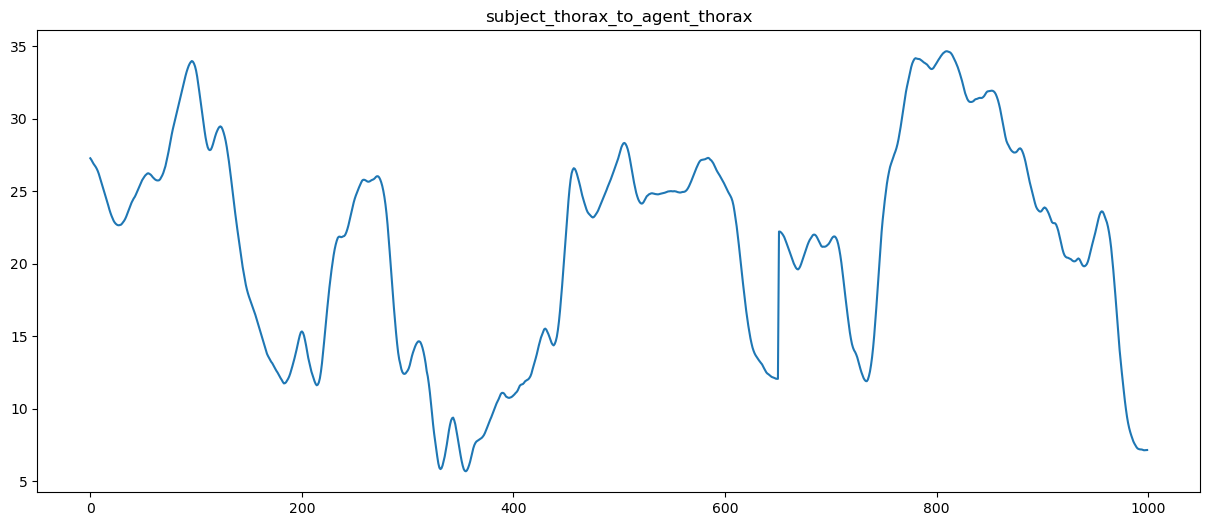

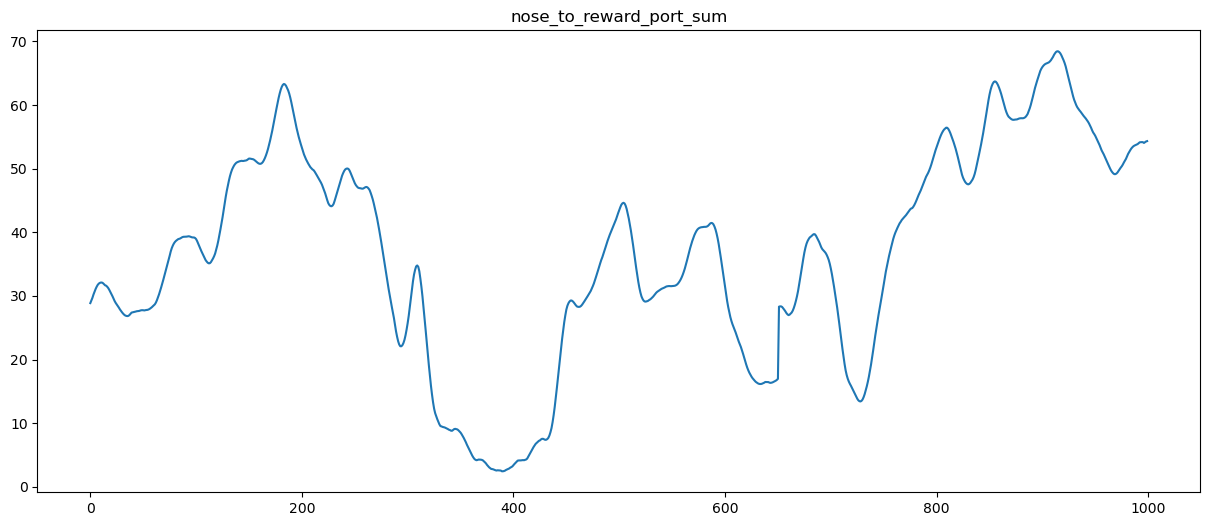

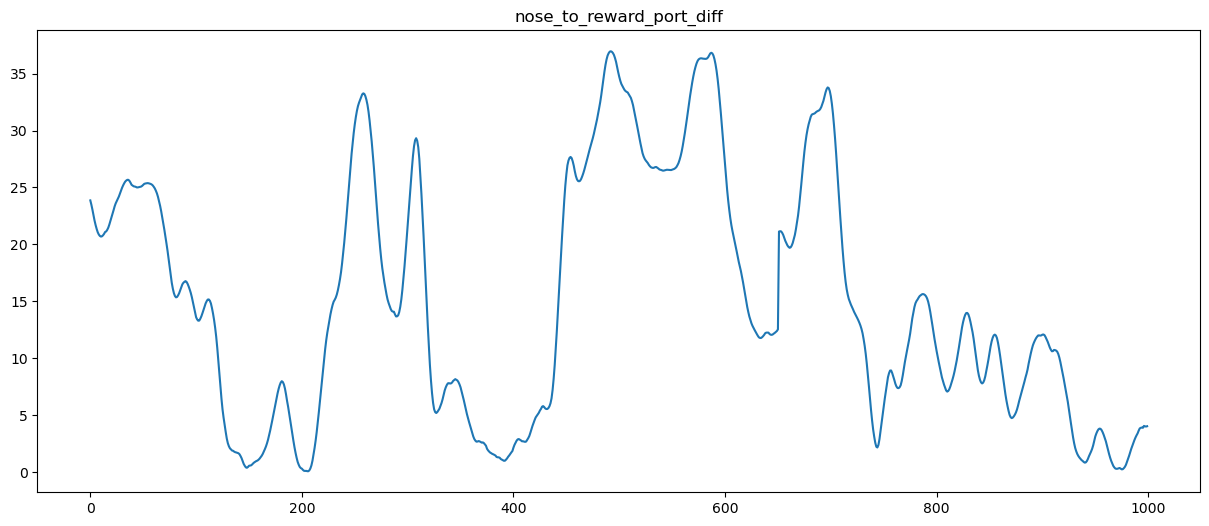

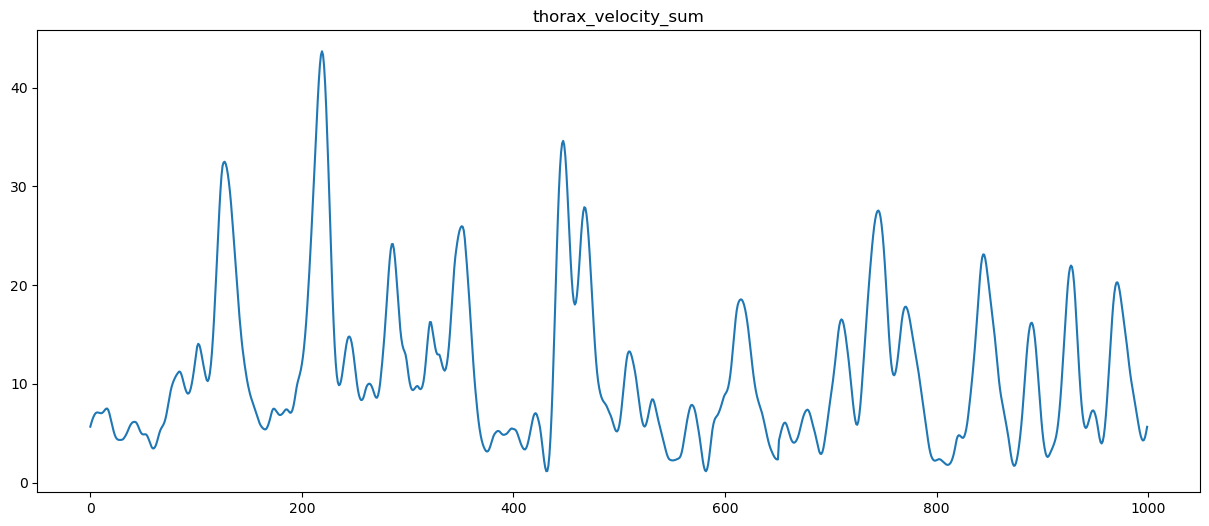

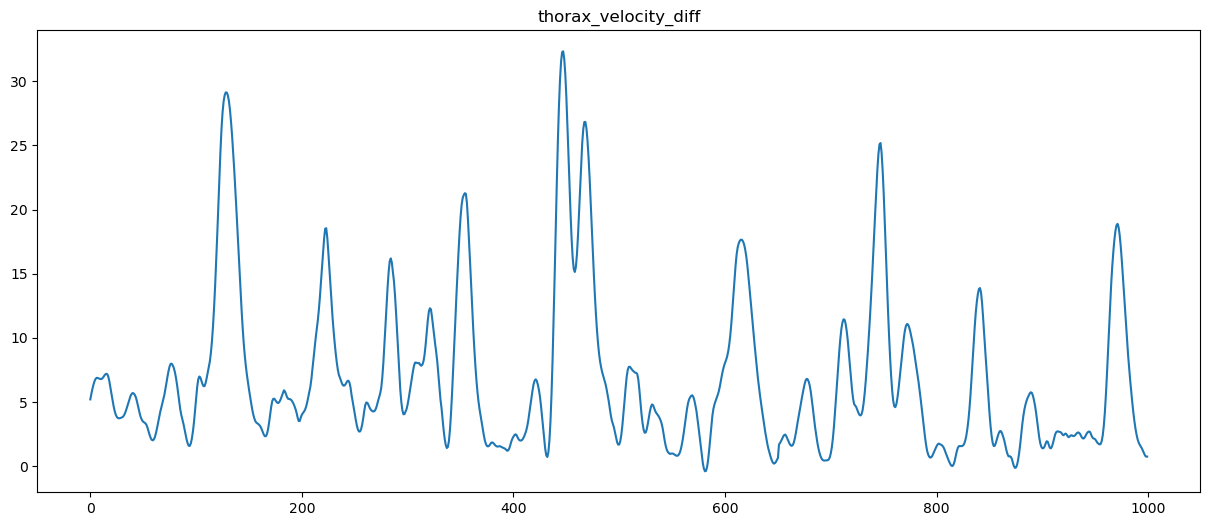

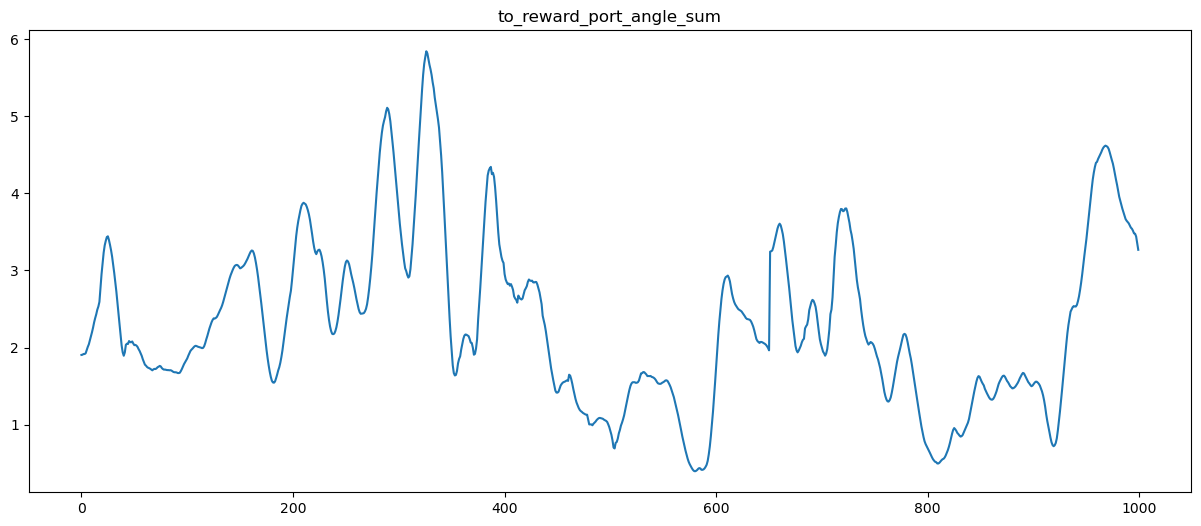

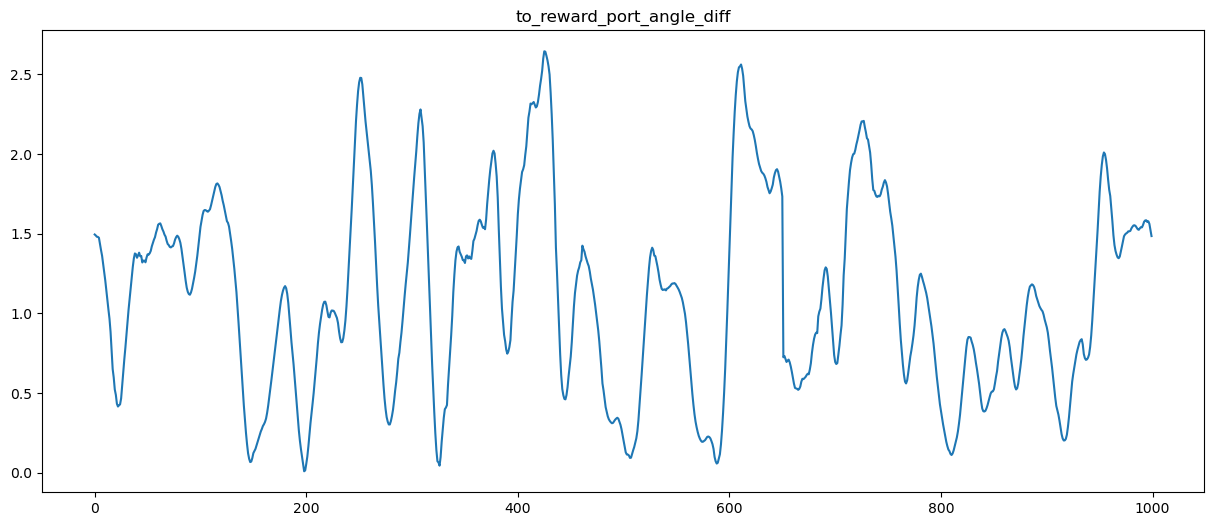

In [215]:
for col in features_columns:
    fig, ax = plt.subplots()
    plt.title(col)
    plt.plot(frame_data[:1000, features_columns.index(col)])
    plt.show()

In [216]:
decay_factor = 0.1

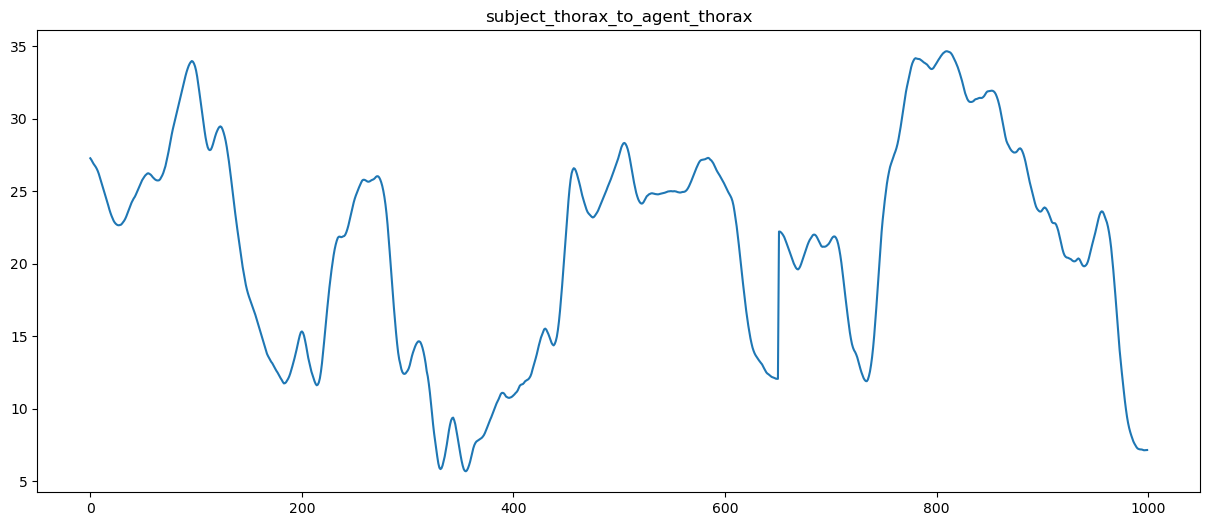

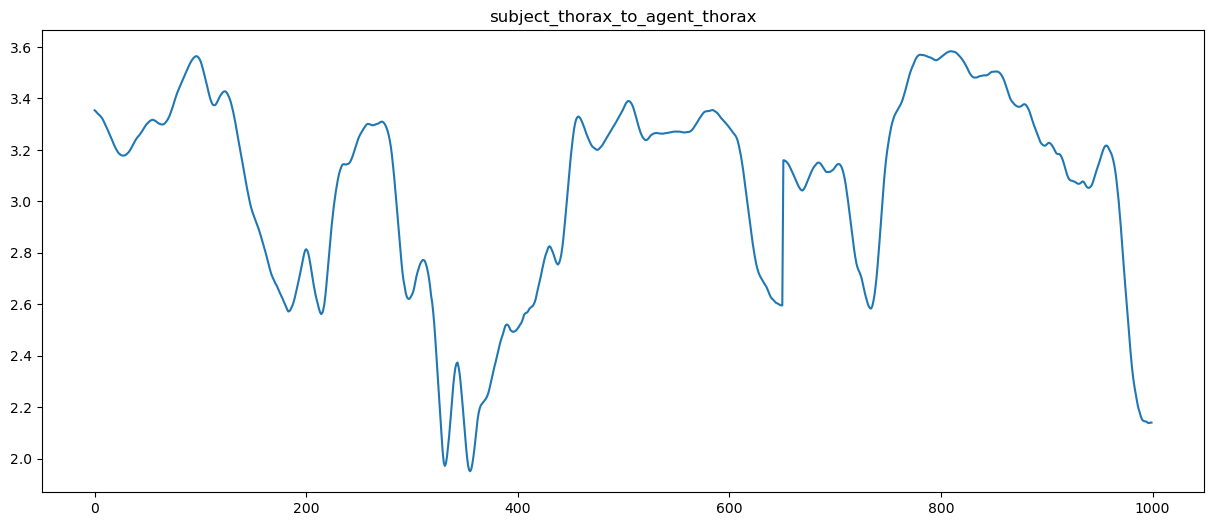

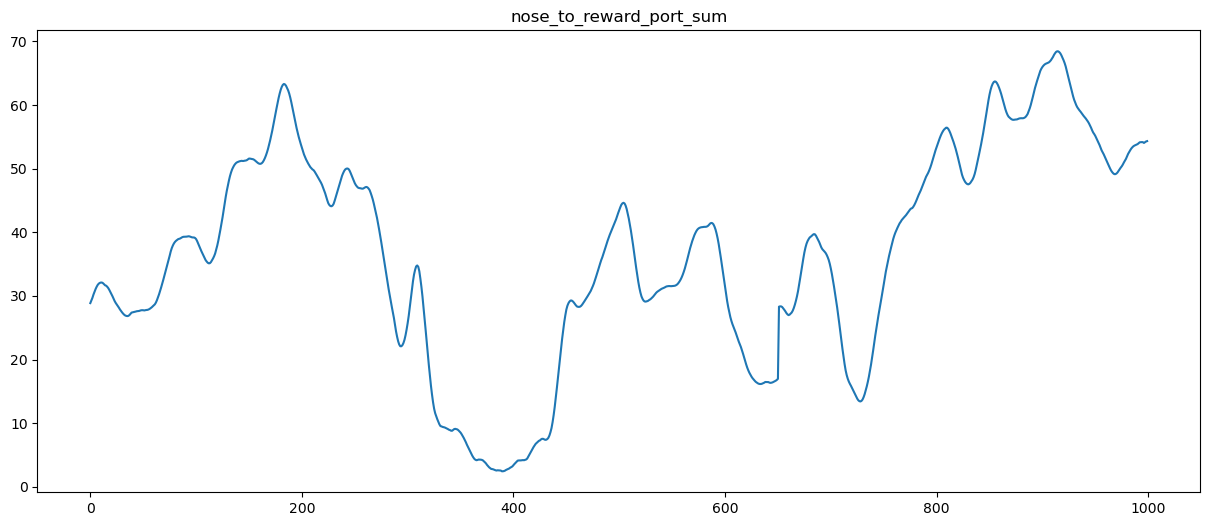

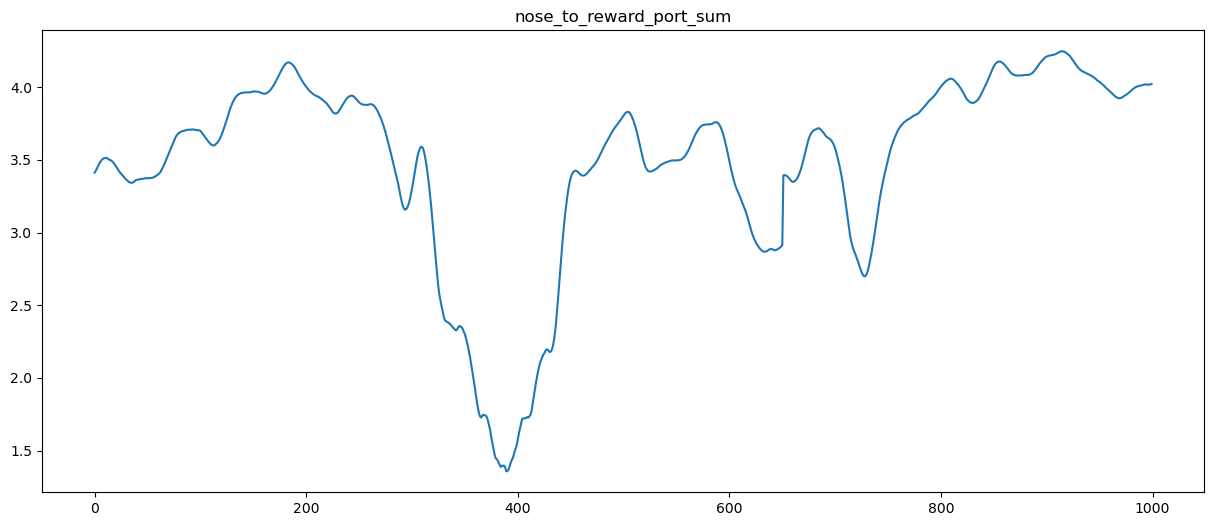

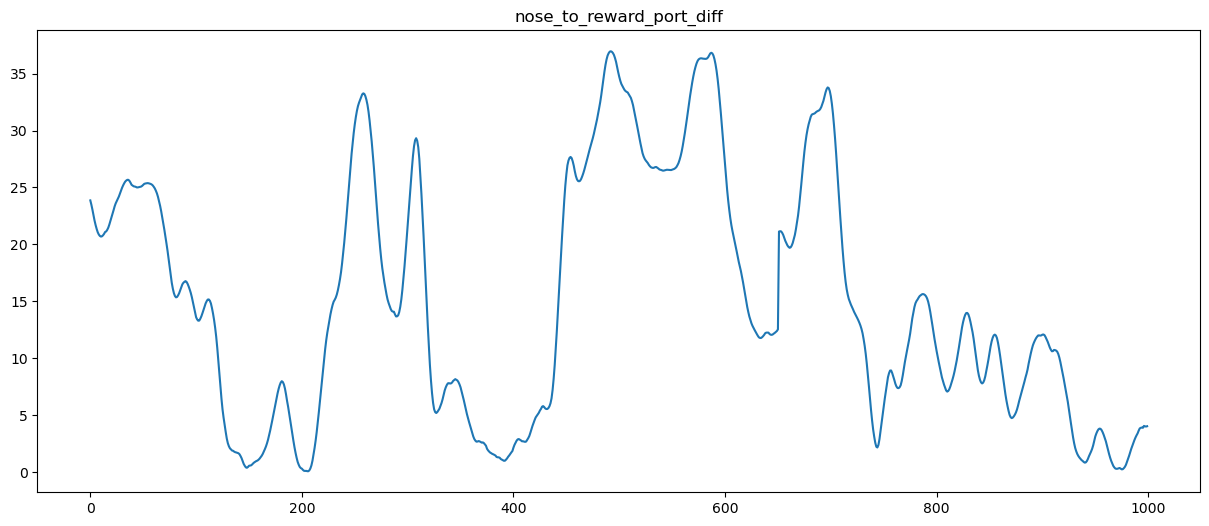

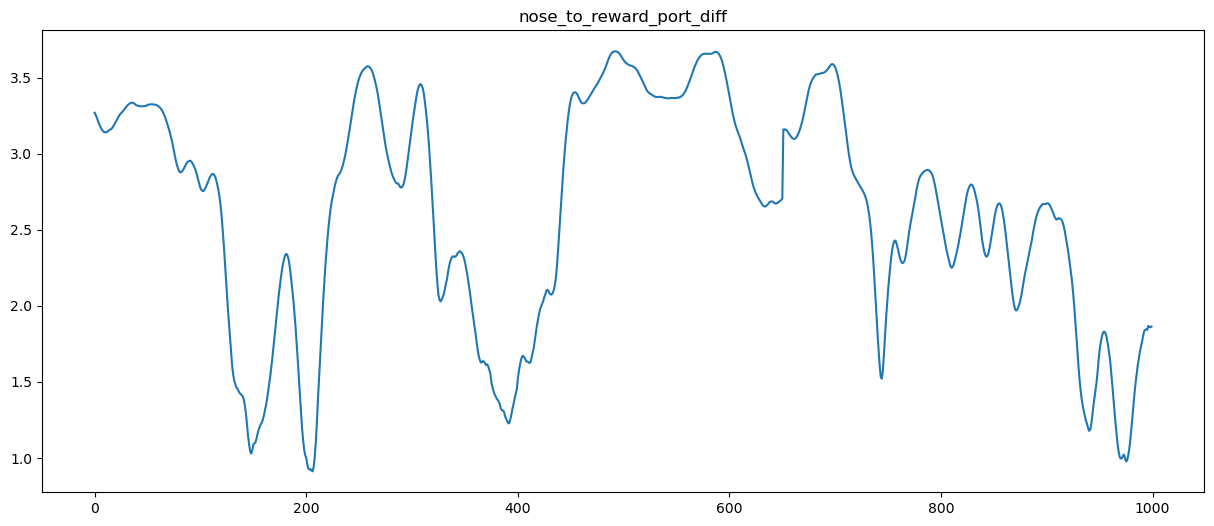

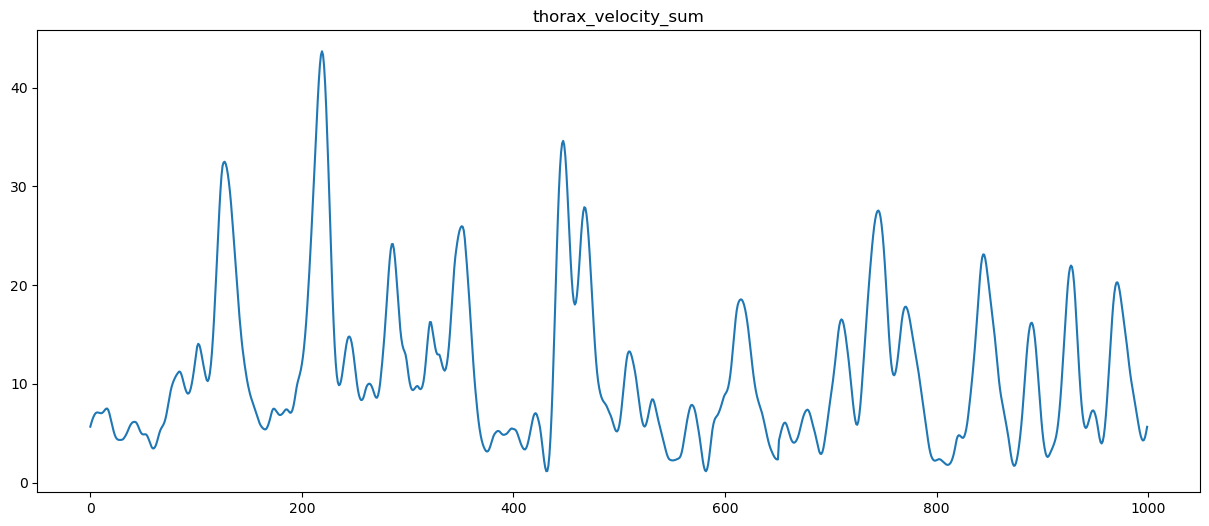

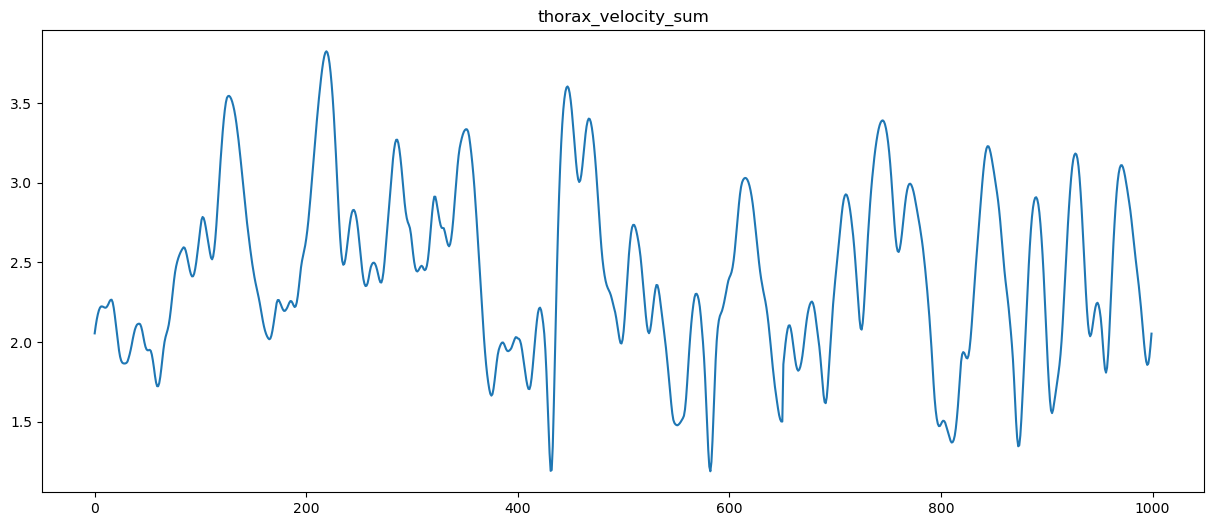

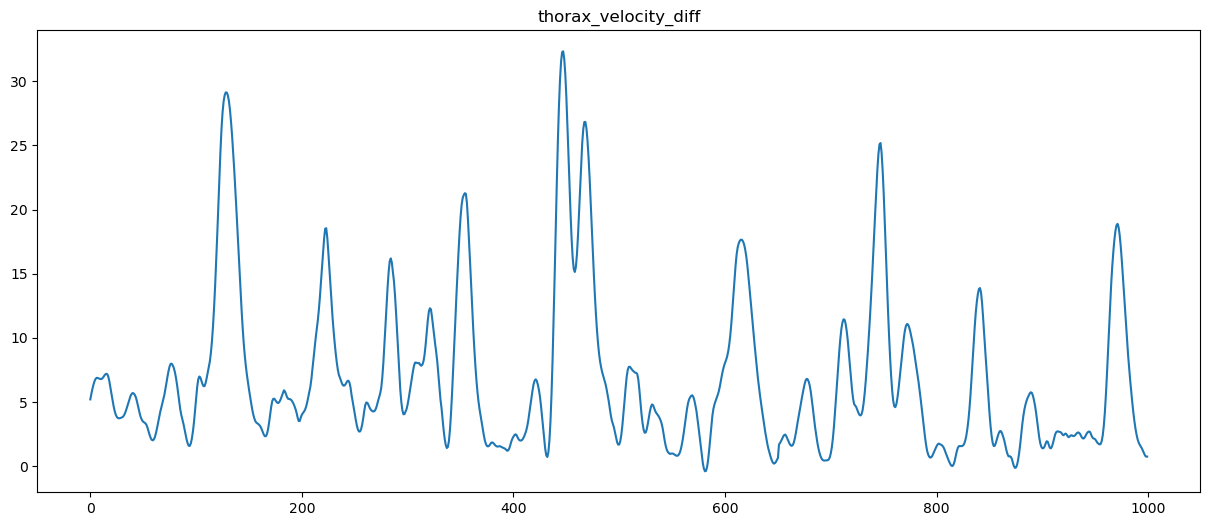

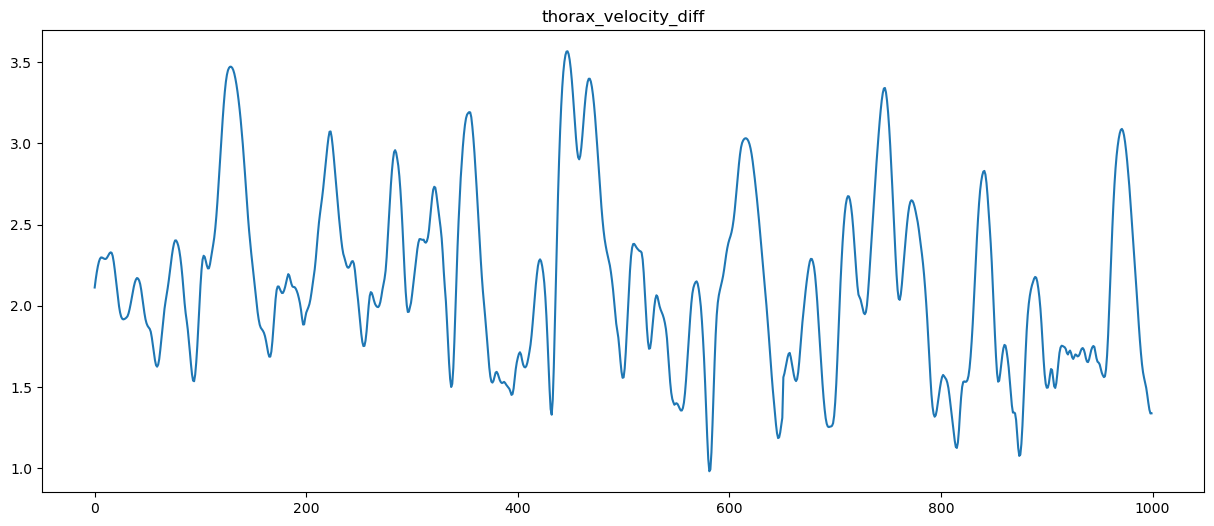

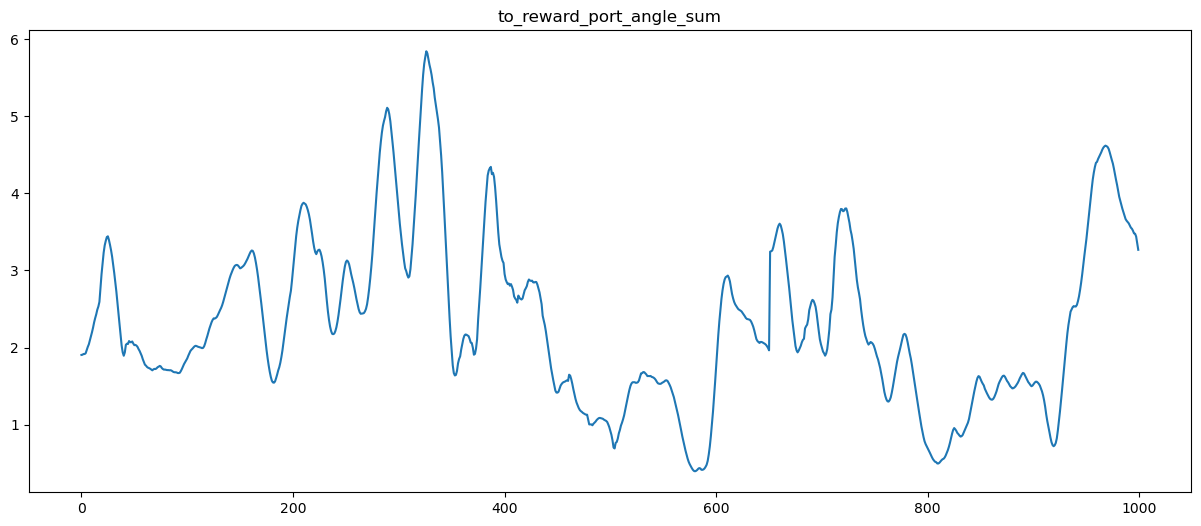

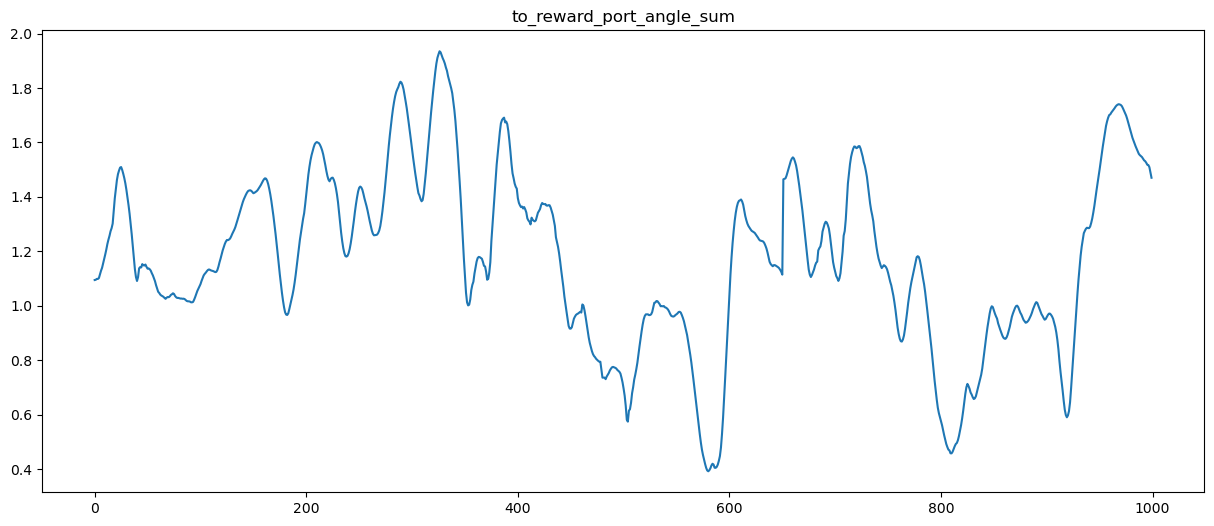

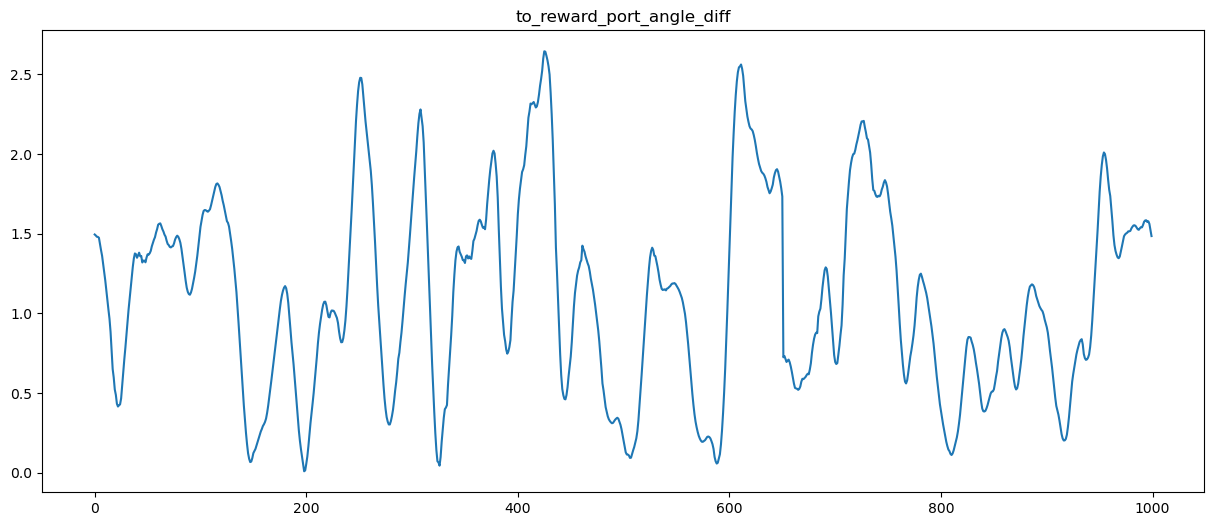

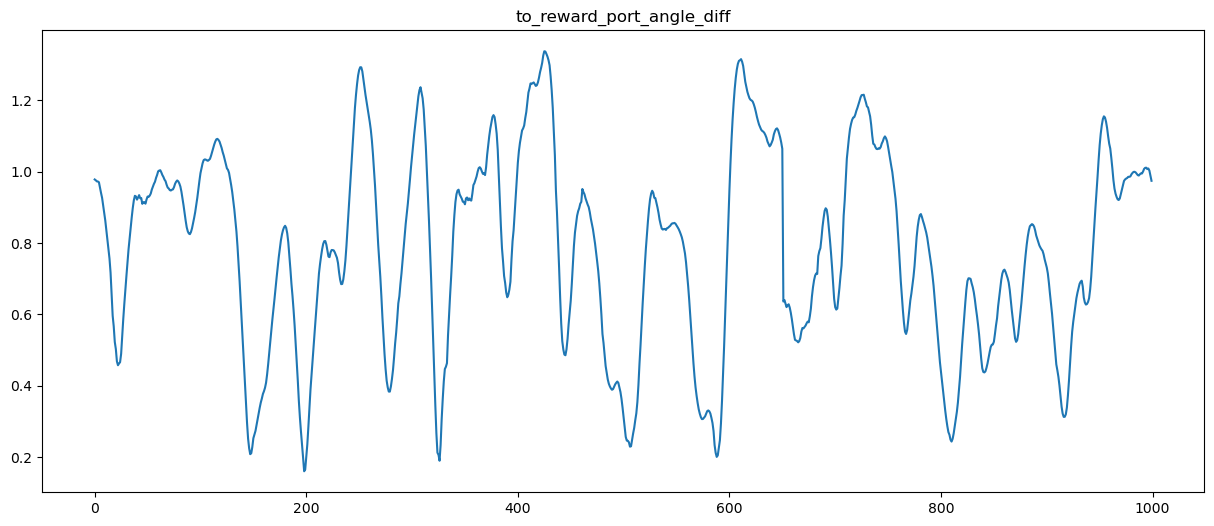

In [217]:
for col in important_features_columns:
    if col not in features_columns:
        continue
    fig, ax = plt.subplots()
    plt.title(col)
    plt.plot(frame_data[:1000, features_columns.index(col)])
    plt.show()
    # frame_data[:, features_columns.index(col)] = np.log(frame_data[:, features_columns.index(col)].astype(float))
    # frame_data[:, features_columns.index(col)] = np.log(frame_data[:, features_columns.index(col)].astype(float) + 5e-1)
    # frame_data[:, features_columns.index(col)] = np.log1p(1/frame_data[:, features_columns.index(col)])

    # frame_data[:, features_columns.index(col)] = 1 / (frame_data[:, features_columns.index(col)] ** scaler)
    frame_data[:, features_columns.index(col)] = np.log1p(frame_data[:, features_columns.index(col)] + np.abs(frame_data[:, features_columns.index(col)].min() * 1.01))

    fig, ax = plt.subplots()
    plt.title(col)
    plt.plot(frame_data[:1000, features_columns.index(col)])
    plt.show()

In [218]:
scaled_frame_data = StandardScaler().fit_transform(frame_data)

# Projecting to lower dimensional space

In [219]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(scaled_frame_data)

In [220]:
drop_duplicates_exploded_columns["standard_embedding_x"] = standard_embedding[:,0]
drop_duplicates_exploded_columns["standard_embedding_y"] = standard_embedding[:,1]

In [221]:
standard_embedding

array([[ 4.6407843 , -5.942454  ],
       [ 4.815408  , -5.755845  ],
       [ 4.959293  , -5.5573306 ],
       ...,
       [-5.116575  , -0.28482905],
       [-5.112485  , -0.2878351 ],
       [-5.1394925 , -0.33249712]], dtype=float32)

In [222]:
clusterable_embedding = umap.UMAP(
    n_neighbors=100,
    min_dist=0,
    n_components=2,
    random_state=42,
).fit_transform(scaled_frame_data)


In [223]:
drop_duplicates_exploded_columns["clusterable_embedding_x"] = clusterable_embedding[:,0]
drop_duplicates_exploded_columns["clusterable_embedding_y"] = clusterable_embedding[:,1]

# Clustering

In [224]:
# kmeans_label_zscore = cluster.KMeans(n_clusters=5, random_state=42).fit_predict(clusterable_embedding)

In [225]:
scaled_frame_data

array([[ 1.3329457 ,  1.24556   ,  1.255472  , ...,  0.43777755,
        -0.05227695,  0.49914274],
       [ 1.3269145 ,  1.2622523 ,  1.2381359 , ...,  0.5224499 ,
        -0.0497169 ,  0.49273604],
       [ 1.3192267 ,  1.2801774 ,  1.2179117 , ...,  0.59444094,
        -0.0405334 ,  0.48375022],
       ...,
       [-1.6624573 , -0.7838674 , -1.230236  , ..., -0.47186565,
         1.9642204 , -1.2949455 ],
       [-1.6554883 , -0.7824869 , -1.2253734 , ..., -0.5213225 ,
         1.977199  , -1.2817556 ],
       [-1.6533446 , -0.78669983, -1.22666   , ..., -0.59320754,
         1.9865988 , -1.2724483 ]], dtype=float32)

In [226]:
kmeans_label_zscore = sklearn.cluster.KMeans(n_clusters=8, random_state=42).fit_predict(clusterable_embedding)

In [227]:
# kmeans_label_zscore = sklearn.cluster.KMeans(n_clusters=8, random_state=42).fit_predict(scaled_frame_data)

In [228]:
# kmeans_label_zscore = cluster.KMeans(n_clusters=8, random_state=42).fit_predict(clusterable_embedding)

In [229]:
# clusterable_embedding.shape[0]//10

In [230]:
# kmeans_label_zscore = hdbscan.HDBSCAN(
#     min_samples=1,
#     min_cluster_size=clusterable_embedding.shape[0]//50,
# ).fit_predict(clusterable_embedding)

In [231]:
drop_duplicates_exploded_columns["kmeans_cluster"] = kmeans_label_zscore

In [232]:
drop_duplicates_exploded_columns["video_name"].unique()

array(['20240227_130241_comp_om_subj_4-2_and_4-3.1',
       '20240228_142038_comp_om_subj_3-1_and_3-3.1',
       '20240228_154053_comp_om_subj_4-3_and_4-4.1',
       '20240229_152936_comp_om_subj_3-3_and_3-4.1',
       '20240317_105929_comp_om_subj_5-3_and_5-4.1',
       '20240318_115841_comp_om_subj_5-2_and_5-3.1',
       '20240319_111204_comp_om_subj_5-2_and_5-4.1',
       '20240325_125522_comp_om_subj_3-1_and_3-4.1',
       '20240325_150329_comp_om_subj_4-2_and_4-4.1',
       '20240317_151922_long_comp_subj_3-1_and_3-3.1',
       '20240317_172017_long_comp_subj_4-2_and_4-3.1',
       '20240318_143819_long_comp_subj_3-3_and_3-4.1',
       '20240318_170933_long_comp_subj_4-3_and_4-4.1',
       '20240319_134914_long_comp_subj_3-1_and_3-4.1',
       '20240319_160457_long_comp_subj_4-2_and_4-4.1',
       '20240320_114629_long_comp_subj_5-3_and_5-4.1',
       '20240321_114851_long_comp_subj_5-2_and_5-3.1',
       '20240320_171038_alone_comp_subj_4-2_and_4-3.1',
       '20240322_120625_alo

In [233]:
drop_duplicates_exploded_columns["video_id"], unique = pd.factorize(drop_duplicates_exploded_columns['video_name'])


In [234]:
drop_duplicates_exploded_columns.columns

Index(['out_reward_frame', 'to_reward_port_angle_sum',
       'subject_to_reward_port_angle', 'body_parts', 'subject_tail_base',
       'subject_nose', 'nose_to_reward_port_sum', 'agent_locations',
       'video_name', 'stop_frame', 'thorax_velocity_sum',
       '10s_before_tone_frame', 'tone_stop_timestamp', 'notes', 'box_top_left',
       'agent_to_reward_port_angle', 'subject_thorax_to_agent_thorax',
       'agent_nose', 'box_bottom_left', 'agent_tail_base',
       'nose_to_reward_port_diff', 'to_reward_port_angle_diff', 'start_frame',
       'agent_thorax', 'last_timestamp', 'box_number', 'frame_index',
       'tone_stop_frame', 'first_timestamp', 'current_subject',
       'tracked_subject', 'competition_closeness', 'get_reward_frame', 'agent',
       'within_trial_frame_index', 'box_top_right', 'tone_start_to_stop_frame',
       'subject_nose_to_reward_port', 'subject_thorax_velocity',
       'in_video_subjects', 'tone_start_frame', 'session_dir',
       'tone_start_timestamp', 'a

In [235]:
export_exploded_columns = pd.merge(merged_exploded_columns, drop_duplicates_exploded_columns[['video_name', 'frame_index', 'standard_embedding_x',
       'standard_embedding_y', 'clusterable_embedding_x',
       'clusterable_embedding_y', 'kmeans_cluster', 'video_id']], on=['video_name', 'frame_index',])

In [236]:
export_exploded_columns.to_pickle("./proc/exploded_columns.pkl")

In [237]:
drop_duplicates_exploded_columns.columns

Index(['out_reward_frame', 'to_reward_port_angle_sum',
       'subject_to_reward_port_angle', 'body_parts', 'subject_tail_base',
       'subject_nose', 'nose_to_reward_port_sum', 'agent_locations',
       'video_name', 'stop_frame', 'thorax_velocity_sum',
       '10s_before_tone_frame', 'tone_stop_timestamp', 'notes', 'box_top_left',
       'agent_to_reward_port_angle', 'subject_thorax_to_agent_thorax',
       'agent_nose', 'box_bottom_left', 'agent_tail_base',
       'nose_to_reward_port_diff', 'to_reward_port_angle_diff', 'start_frame',
       'agent_thorax', 'last_timestamp', 'box_number', 'frame_index',
       'tone_stop_frame', 'first_timestamp', 'current_subject',
       'tracked_subject', 'competition_closeness', 'get_reward_frame', 'agent',
       'within_trial_frame_index', 'box_top_right', 'tone_start_to_stop_frame',
       'subject_nose_to_reward_port', 'subject_thorax_velocity',
       'in_video_subjects', 'tone_start_frame', 'session_dir',
       'tone_start_timestamp', 'a